In [1]:
import os
import cv2 as cv
import numpy as np
import math
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv
import codecs
import scipy.io as scio
import pandas as pd
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.io as scio
from pylab import *
import scipy.io as scio
import matplotlib.dates as mdates  

# Function

In [60]:
# the following part creates a new class which is similar to dictionary but can store dictionary data type in it. 
class Vividict(dict):
    def __missing__(self, key):
        value = self[key] = type(self)()
        return value
    
def Gopro_videoOrder(path):
    # this function is trying to sort the order of GoPro video because the default order by name in the computer
    # is not the real temporal order of the videos
    # 这个函数的作用是将GoPro的视频根据时间顺序重新排序，GoPro在生成视频文件的时候有自己的命名体系，但是电脑的默认名称排序与真实的时间
    # 排序不一致。
    # input: path, the path of unprocessed images folder of GoPro videos
    video_list = os.listdir(path)
    for i in range(len(video_list)-1):
        min_index = i
        for j in range(i, len(video_list)-1):
            if int(video_list[min_index][6:8]) > int(video_list[j+1][6:8]):
                min_index = j + 1
            elif int(video_list[min_index][6:8]) == int(video_list[j+1][6:8]):
                if int(video_list[min_index][2:4]) > int(video_list[j+1][2:4]):
                    min_index = j + 1
        swap_video = video_list[min_index]
        video_list[min_index] = video_list[i]
        video_list[i] = swap_video
    return video_list

def Gopro_videoCombine(video_list, path_unprocessed, path_WFcsv):
    # this function is trying to include all the whitecap fraction of the GoPro videos taken in one day 
    # in a variable with dictionary data type. The key of this dictionary is the name of the video. 
    # the value is also a dictionary data type variable. The value contains the whitecap fraction and the image order
    # respectively. 
    # 这个函数的作用是将原本一个视频一个whitecap数据文件的数据整合在一起。为了便于确认时间顺序的正确性，每一个视频文件夹里面的数据是一个
    # dictionary，其中key是图片的顺序，value是whitecap fraction的值。然后再将这些dictionary存在一个新的dictionary中，新的
    # dictionary中key是视频的名称，值是存储了每个视频数据的dictionary。
    # 原本也是可以直接将一天的视频数据全部连接在一起成为一个list。我这样做的原因主要是为了保证顺序的正确，方便事后的校对。
    # input: video_list, the list of video name which has been sorted by Gopro_videoOrder function
    #        path_unprocessed, the path of unprocessed images folder of GoPro videos
    #        paht_WFcsv, the path of the folder including the whitecap fraction .csv data
    video_image = Vividict()
    for i in range(0, len(video_list)):
        image_list = os.listdir(path_unprocessed + "/" + video_list[i])
        for img in image_list[:]:
            if img[0:2] == '._':
                image_list.remove(img)
        image_list.sort(key=lambda x:int(x[14:-4]))
        for j in range(0, len(image_list)):
            video_image[video_list[i]][image_list[j]] = np.nan
            # the reason for that is because some images in a video has been deleted because of the glints. 
            # 上面这段可以让由于反光等各种因素被删除的图片也占一个时间，这样在做时域分析的时候便于对应
            data_wf = []
            path = path_WFcsv + "/" + video_list[i] + "/"
            if video_list[i] not in os.listdir(path_WFcsv):
                continue
            else:
                with open(path + video_list[i][0:8] + "_ATS_wf.csv") as csvfile: 
                    csv_reader = csv.reader(csvfile, delimiter = ' ', quotechar = ' ')
                    for row in csv_reader:
                        for n in row:
                            data_wf.append(float(n))
                if j < len(data_wf):
                    video_image[video_list[i]][image_list[j]] = data_wf[j]
                else:
                    continue
    return video_image


def SecTo20min(video_list, video_image):
    wf_second = []
    wf_20min = []
    for n in range(len(video_list)):
        wf_second.extend(video_image[video_list[n]].values())
    for i in range(len(wf_second) // 1200):
        realnum = 1200
        for j in range(1200):
            if np.isnan(wf_second[i*1200+j]):
                realnum = realnum - 1
                wf_second[i*1200+j] = 0
        if realnum == 0:
            wf_20min.append(0)
        else:
            wf_20min.append(sum(wf_second[i*1200:(i*1200+1199)])/realnum)
    return wf_20min

# Load Whitecaps Data

In [61]:
video_list_4l = Gopro_videoOrder("F:/2ndProcessedGoPro/2020_3_4_GoPro/image_left")
video_list_5l = Gopro_videoOrder("F:/2ndProcessedGoPro/2020_3_5_GoPro/image_left")
video_list_6l = Gopro_videoOrder("F:/2ndProcessedGoPro/2020_3_6_GoPro/image_left")
video_list_7l = Gopro_videoOrder("F:/2ndProcessedGoPro/2020_3_7_GoPro/image_left")

path_unprocessed = "F:/2ndProcessedGoPro/2020_3_4_GoPro/image_left"
path_WFcsv = "F:/GoPro_manuallly_checked_processed/2020_3_4_GoPro/processed_left"
video_image_4l = Gopro_videoCombine(video_list_4l, path_unprocessed, path_WFcsv)

path_unprocessed = "F:/2ndProcessedGoPro/2020_3_5_GoPro/image_left"
path_WFcsv = "F:/GoPro_manuallly_checked_processed/2020_3_5_GoPro/processed_left"
video_image_5l = Gopro_videoCombine(video_list_5l, path_unprocessed, path_WFcsv)

path_unprocessed = "F:/2ndProcessedGoPro/2020_3_6_GoPro/image_left"
path_WFcsv = "F:/GoPro_manuallly_checked_processed/2020_3_6_GoPro/processed_left"
video_image_6l = Gopro_videoCombine(video_list_6l, path_unprocessed, path_WFcsv) 

path_unprocessed = "F:/2ndProcessedGoPro/2020_3_7_GoPro/image_left"
path_WFcsv = "F:/GoPro_manuallly_checked_processed/2020_3_7_GoPro/processed_left"
video_image_7l = Gopro_videoCombine(video_list_7l, path_unprocessed, path_WFcsv) 

wf_4l_20min = SecTo20min(video_list_4l, video_image_4l)
wf_5l_20min = SecTo20min(video_list_5l, video_image_5l)
wf_6l_20min = SecTo20min(video_list_6l, video_image_6l)
wf_7l_20min = SecTo20min(video_list_7l, video_image_7l)

In [62]:
print(f"2020.3.4 points number: {len(wf_4l_20min)}; time: {len(wf_4l_20min)*20} min ({len(wf_4l_20min)*20/60} h)")
print(f"2020.3.5 points number: {len(wf_5l_20min)}; time: {len(wf_5l_20min)*20} min ({len(wf_5l_20min)*20/60} h)")
print(f"2020.3.6 points number: {len(wf_6l_20min)}; time: {len(wf_6l_20min)*20} min ({len(wf_6l_20min)*20/60} h)")
print(f"2020.3.7 points number: {len(wf_7l_20min)}; time: {len(wf_7l_20min)*20} min ({len(wf_7l_20min)*20/60} h)")

2020.3.4 points number: 11; time: 220 min (3.6666666666666665 h)
2020.3.5 points number: 22; time: 440 min (7.333333333333333 h)
2020.3.6 points number: 22; time: 440 min (7.333333333333333 h)
2020.3.7 points number: 23; time: 460 min (7.666666666666667 h)


In [63]:
wf = wf_4l_20min + wf_5l_20min + wf_6l_20min + wf_7l_20min

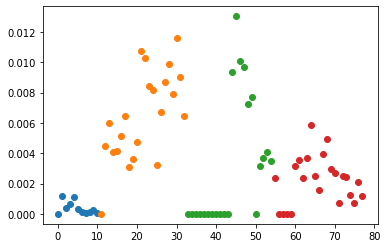

In [64]:
plt.scatter(np.arange(len(wf_4l_20min)), wf_4l_20min)
plt.scatter(np.arange(len(wf_4l_20min), len(wf_4l_20min) + len(wf_5l_20min), 1), wf_5l_20min)
plt.scatter(np.arange(len(wf_4l_20min) + len(wf_5l_20min), len(wf_4l_20min) + len(wf_5l_20min) + len(wf_6l_20min), 1), wf_6l_20min)
plt.scatter(np.arange(len(wf_4l_20min) + len(wf_5l_20min) + len(wf_6l_20min), len(wf_4l_20min) + len(wf_5l_20min) + len(wf_6l_20min)
                      + len(wf_7l_20min), 1), wf_7l_20min)

In [65]:
video_list_4l = Gopro_videoOrder("E:/GoPro_1Hz_Unet_output/2020_3_4_GoPro/image_left")
video_list_5l = Gopro_videoOrder("E:/GoPro_1Hz_Unet_output/2020_3_5_GoPro/image_left")
video_list_6l = Gopro_videoOrder("E:/GoPro_1Hz_Unet_output/2020_3_6_GoPro/image_left")
video_list_7l = Gopro_videoOrder("E:/GoPro_1Hz_Unet_output/2020_3_7_GoPro/image_left")

active_data_4l = pd.DataFrame()
data_path = "E:/GoPro_1Hz_Unet_output/2020_3_4_GoPro/image_left"

for fname in video_list_4l:
    video_data = pd.read_csv(os.path.join(data_path, fname))
    active_data_4l = active_data_4l.append(video_data[['video','active_whitecaps_fraction']])
    
active_data_5l = pd.DataFrame()
data_path = "E:/GoPro_1Hz_Unet_output/2020_3_5_GoPro/image_left"

for fname in video_list_5l:
    video_data = pd.read_csv(os.path.join(data_path, fname))
    active_data_5l = active_data_5l.append(video_data[['video','active_whitecaps_fraction']])
    
active_data_6l = pd.DataFrame()
data_path = "E:/GoPro_1Hz_Unet_output/2020_3_6_GoPro/image_left"

for fname in video_list_6l:
    video_data = pd.read_csv(os.path.join(data_path, fname))
    active_data_6l = active_data_6l.append(video_data[['video','active_whitecaps_fraction']])
    
active_data_7l = pd.DataFrame()
data_path = "E:/GoPro_1Hz_Unet_output/2020_3_7_GoPro/image_left"

for fname in video_list_7l:
    video_data = pd.read_csv(os.path.join(data_path, fname))
    active_data_7l = active_data_7l.append(video_data[['video','active_whitecaps_fraction']])
    
wf_second = active_data_4l['active_whitecaps_fraction'].values
wf_20min_active_4l = []
for i in range(0, int(len(wf_second)/1200)):
    realnum = 1200
    for j in range(0, 1200):
        if np.isnan(wf_second[i*1200+j]):
            realnum = realnum - 1
            wf_second[i*1200+j] = 0
    if realnum == 0:
        wf_20min_active_4l.append(0)
    else:
        wf_20min_active_4l.append(sum(wf_second[i*1200:(i*1200+1199)])/realnum)
        
wf_second = active_data_5l['active_whitecaps_fraction'].values
wf_20min_active_5l = []
for i in range(0, int(len(wf_second)/1200)):
    realnum = 1200
    for j in range(0, 1200):
        if np.isnan(wf_second[i*1200+j]):
            realnum = realnum - 1
            wf_second[i*1200+j] = 0
    if realnum == 0:
        wf_20min_active_5l.append(0)
    else:
        wf_20min_active_5l.append(sum(wf_second[i*1200:(i*1200+1199)])/realnum)
        
wf_second = active_data_6l['active_whitecaps_fraction'].values
wf_20min_active_6l = []
for i in range(0, int(len(wf_second)/1200)):
    realnum = 1200
    for j in range(0, 1200):
        if np.isnan(wf_second[i*1200+j]):
            realnum = realnum - 1
            wf_second[i*1200+j] = 0
    if realnum == 0:
        wf_20min_active_6l.append(0)
    else:
        wf_20min_active_6l.append(sum(wf_second[i*1200:(i*1200+1199)])/realnum)
        
wf_second = active_data_7l['active_whitecaps_fraction'].values
wf_20min_active_7l = []
for i in range(0, int(len(wf_second)/1200)):
    realnum = 1200
    for j in range(0, 1200):
        if np.isnan(wf_second[i*1200+j]):
            realnum = realnum - 1
            wf_second[i*1200+j] = 0
    if realnum == 0:
        wf_20min_active_7l.append(0)
    else:
        wf_20min_active_7l.append(sum(wf_second[i*1200:(i*1200+1199)])/realnum)

In [66]:
print(f"2020.3.4 points number: {len(wf_20min_active_4l)}; time: {len(wf_20min_active_4l)*20} min ({len(wf_20min_active_4l)*20/60} h)")
print(f"2020.3.5 points number: {len(wf_20min_active_5l)}; time: {len(wf_20min_active_5l)*20} min ({len(wf_20min_active_5l)*20/60} h)")
print(f"2020.3.6 points number: {len(wf_20min_active_6l)}; time: {len(wf_20min_active_6l)*20} min ({len(wf_20min_active_6l)*20/60} h)")
print(f"2020.3.7 points number: {len(wf_20min_active_7l)}; time: {len(wf_20min_active_7l)*20} min ({len(wf_20min_active_7l)*20/60} h)")

2020.3.4 points number: 11; time: 220 min (3.6666666666666665 h)
2020.3.5 points number: 22; time: 440 min (7.333333333333333 h)
2020.3.6 points number: 22; time: 440 min (7.333333333333333 h)
2020.3.7 points number: 23; time: 460 min (7.666666666666667 h)


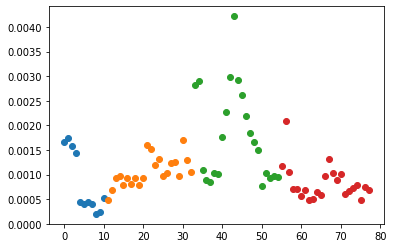

In [67]:
plt.scatter(np.arange(len(wf_20min_active_4l)), wf_20min_active_4l)
plt.scatter(np.arange(len(wf_20min_active_4l), len(wf_20min_active_4l) + len(wf_20min_active_5l), 1), wf_20min_active_5l)
plt.scatter(np.arange(len(wf_20min_active_4l) + len(wf_20min_active_5l), len(wf_20min_active_4l) + len(wf_20min_active_5l) + len(wf_20min_active_6l), 1), wf_20min_active_6l)
plt.scatter(np.arange(len(wf_20min_active_4l) + len(wf_20min_active_5l) + len(wf_20min_active_6l), len(wf_20min_active_4l) + len(wf_20min_active_5l) + len(wf_20min_active_6l)
                      + len(wf_20min_active_7l), 1), wf_20min_active_7l)

In [68]:
wf_20min_active_4l

[0.0016592686215969425,
 0.0017338108887717193,
 0.0015788204883991595,
 0.0014430546562004464,
 0.00043490209017773434,
 0.00039738336030088896,
 0.0004449115717546968,
 0.0003980091032260314,
 0.00019875429741729036,
 0.00022917104959739143,
 0.0005206634924969677]

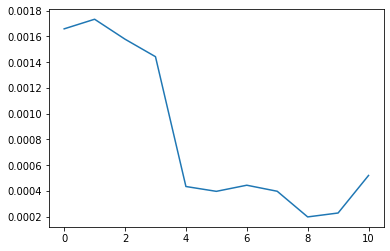

In [69]:
plt.plot(wf_20min_active_4l)

## From the right camera

In [70]:
video_list_4r = Gopro_videoOrder("E:/GoPro_1Hz_Unet_output/2020_3_4_GoPro/image_right")
video_list_5r = Gopro_videoOrder("E:/GoPro_1Hz_Unet_output/2020_3_5_GoPro/image_right")
video_list_6r = Gopro_videoOrder("E:/GoPro_1Hz_Unet_output/2020_3_6_GoPro/image_right")
video_list_7r = Gopro_videoOrder("E:/GoPro_1Hz_Unet_output/2020_3_7_GoPro/image_right")

active_data_4r = pd.DataFrame()
data_path = "E:/GoPro_1Hz_Unet_output/2020_3_4_GoPro/image_right"

for fname in video_list_4r:
    video_data = pd.read_csv(os.path.join(data_path, fname))
    active_data_4r = active_data_4r.append(video_data[['video','active_whitecaps_fraction']])
    
active_data_5r = pd.DataFrame()
data_path = "E:/GoPro_1Hz_Unet_output/2020_3_5_GoPro/image_right"

for fname in video_list_5r:
    video_data = pd.read_csv(os.path.join(data_path, fname))
    active_data_5r = active_data_5r.append(video_data[['video','active_whitecaps_fraction']])
    
active_data_6r = pd.DataFrame()
data_path = "E:/GoPro_1Hz_Unet_output/2020_3_6_GoPro/image_right"

for fname in video_list_6r:
    video_data = pd.read_csv(os.path.join(data_path, fname))
    active_data_6r = active_data_6r.append(video_data[['video','active_whitecaps_fraction']])
    
active_data_7r = pd.DataFrame()
data_path = "E:/GoPro_1Hz_Unet_output/2020_3_7_GoPro/image_right"

for fname in video_list_7r:
    video_data = pd.read_csv(os.path.join(data_path, fname))
    active_data_7r = active_data_7r.append(video_data[['video','active_whitecaps_fraction']])
    
wf_second = active_data_4r['active_whitecaps_fraction'].values
wf_20min_active_4r = []
for i in range(0, int(len(wf_second)/1200)):
    realnum = 1200
    for j in range(0, 1200):
        if np.isnan(wf_second[i*1200+j]):
            realnum = realnum - 1
            wf_second[i*1200+j] = 0
    if realnum == 0:
        wf_20min_active_4r.append(0)
    else:
        wf_20min_active_4r.append(sum(wf_second[i*1200:(i*1200+1199)])/realnum)
        
wf_second = active_data_5r['active_whitecaps_fraction'].values
wf_20min_active_5r = []
for i in range(0, int(len(wf_second)/1200)):
    realnum = 1200
    for j in range(0, 1200):
        if np.isnan(wf_second[i*1200+j]):
            realnum = realnum - 1
            wf_second[i*1200+j] = 0
    if realnum == 0:
        wf_20min_active_5r.append(0)
    else:
        wf_20min_active_5r.append(sum(wf_second[i*1200:(i*1200+1199)])/realnum)
        
wf_second = active_data_6r['active_whitecaps_fraction'].values
wf_20min_active_6r = []
for i in range(0, int(len(wf_second)/1200)):
    realnum = 1200
    for j in range(0, 1200):
        if np.isnan(wf_second[i*1200+j]):
            realnum = realnum - 1
            wf_second[i*1200+j] = 0
    if realnum == 0:
        wf_20min_active_6r.append(0)
    else:
        wf_20min_active_6r.append(sum(wf_second[i*1200:(i*1200+1199)])/realnum)
        
wf_second = active_data_7r['active_whitecaps_fraction'].values
wf_20min_active_7r = []
for i in range(0, int(len(wf_second)/1200)):
    realnum = 1200
    for j in range(0, 1200):
        if np.isnan(wf_second[i*1200+j]):
            realnum = realnum - 1
            wf_second[i*1200+j] = 0
    if realnum == 0:
        wf_20min_active_7r.append(0)
    else:
        wf_20min_active_7r.append(sum(wf_second[i*1200:(i*1200+1199)])/realnum)

In [71]:
print(f"2020.3.4 points number: {len(wf_20min_active_4r)}; time: {len(wf_20min_active_4r)*20} min ({len(wf_20min_active_4r)*20/60} h)")
print(f"2020.3.5 points number: {len(wf_20min_active_5r)}; time: {len(wf_20min_active_5r)*20} min ({len(wf_20min_active_5r)*20/60} h)")
print(f"2020.3.6 points number: {len(wf_20min_active_6r)}; time: {len(wf_20min_active_6r)*20} min ({len(wf_20min_active_6r)*20/60} h)")
print(f"2020.3.7 points number: {len(wf_20min_active_7r)}; time: {len(wf_20min_active_7r)*20} min ({len(wf_20min_active_7r)*20/60} h)")

2020.3.4 points number: 10; time: 200 min (3.3333333333333335 h)
2020.3.5 points number: 22; time: 440 min (7.333333333333333 h)
2020.3.6 points number: 20; time: 400 min (6.666666666666667 h)
2020.3.7 points number: 21; time: 420 min (7.0 h)


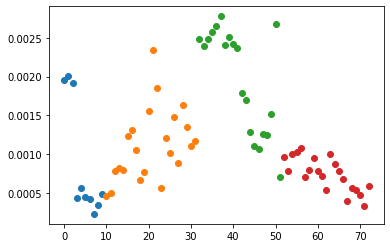

In [72]:
plt.scatter(np.arange(len(wf_20min_active_4r)), wf_20min_active_4r)
plt.scatter(np.arange(len(wf_20min_active_4r), len(wf_20min_active_4r) + len(wf_20min_active_5r), 1), wf_20min_active_5r)
plt.scatter(np.arange(len(wf_20min_active_4r) + len(wf_20min_active_5r), len(wf_20min_active_4r) + len(wf_20min_active_5r) + len(wf_20min_active_6r), 1), wf_20min_active_6r)
plt.scatter(np.arange(len(wf_20min_active_4r) + len(wf_20min_active_5r) + len(wf_20min_active_6r), len(wf_20min_active_4r) + len(wf_20min_active_5r) + len(wf_20min_active_6r)
                      + len(wf_20min_active_7r), 1), wf_20min_active_7r)

In [73]:
x = np.linspace(0, 0.004,5)

In [74]:
x

array([0.   , 0.001, 0.002, 0.003, 0.004])

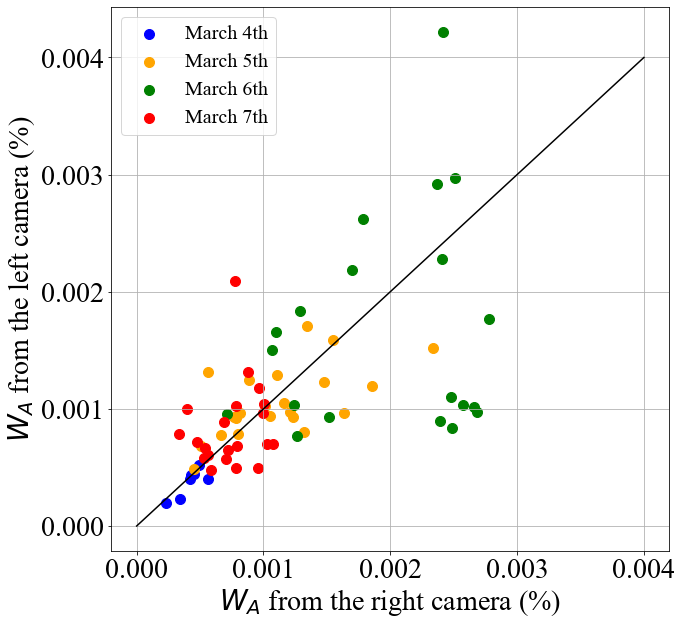

In [75]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)

yticks = [0, 0.001, 0.002, 0.003, 0.004]
font_legend = {'family' : 'Times New Roman', 
        'weight' : 'normal', 
        'size' : 28}

plt.scatter(wf_20min_active_4r[3:], wf_20min_active_4l[4:], color = 'blue',s=100, label='March 4th')
plt.scatter(wf_20min_active_5r, wf_20min_active_5l,color = 'orange',s=100, label='March 5th')
plt.scatter(wf_20min_active_6r, wf_20min_active_6l[2:],color = 'green',s=100, label='March 6th')
plt.scatter(wf_20min_active_7r, wf_20min_active_7l[:-2],color = 'red',s=100, label='March 7th')

x = np.linspace(0, 0.004,5)
plt.plot(x, x, color = 'black')
plt.grid()

ax.set_ylabel("$W_{A}$ from the left camera (%)",font_legend)
ax.set_xlabel("$W_{A}$ from the right camera (%)",font_legend)
plt.xticks(yticks,fontsize=28, fontproperties='Times New Roman')
plt.yticks(yticks, fontsize=28, fontproperties='Times New Roman')

font_legend1 = {'family' : 'Times New Roman', 
        'weight' : 'normal', 
        'size' : 20}

plt.legend(prop = font_legend1)

# Load Wind Data

In [76]:
wind_time = pd.read_csv('E:\OneDrive - Texas A&M University\Buoy Data near Cruise/WindsByScott_time.csv',
                        sep=' ',names=['time'],header=None)
data = pd.read_csv('E:\OneDrive - Texas A&M University\Buoy Data near Cruise/WindsByScott_10hz.csv',
                   sep=' ',names=['uc', 'vc', 'wc'],header=None)
wind_time.apply(pd.to_datetime, axis==0)
wind_data = pd.concat([wind_time, data], axis=1)

In [77]:
wind_data['time'] = pd.to_datetime(wind_data['time'])
wind_data = wind_data.set_index('time')
wind_data

,uc,vc,wc
time,,,
2020-03-04 14:02:08.100,4.925037,-1.859924,1.561179
2020-03-04 14:02:08.200,5.528047,-1.923758,1.584634
2020-03-04 14:02:08.300,6.126599,-1.953701,1.590702
2020-03-04 14:02:08.400,6.717620,-1.949854,1.579901
2020-03-04 14:02:08.500,7.139373,-1.870966,1.528747
...,...,...,...
2020-03-07 16:39:59.600,5.222269,-0.252898,0.143343
2020-03-07 16:39:59.700,5.205064,-0.215021,0.080588
2020-03-07 16:39:59.800,5.151119,-0.176155,0.182312


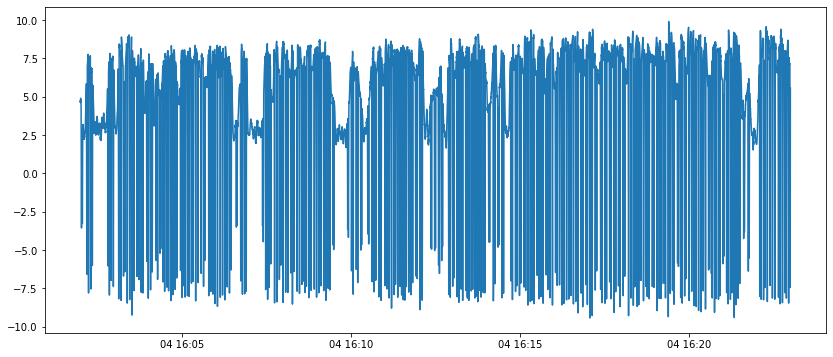

In [78]:
fig, ax = plt.subplots(figsize=(14, 6))
plt.plot(wind_data['2020-03-04 16:02':'2020-03-04 16:22']['uc'])

In [79]:
wind_time_20min = pd.read_csv('E:\OneDrive - Texas A&M University\Buoy Data near Cruise/WindsByScott_time_20min.csv',
                        sep=' ',names=['time'],header=None)
data_20min = pd.read_csv('E:\OneDrive - Texas A&M University\Buoy Data near Cruise/WindsByScott_20min.csv',
                   sep=' ',names=['ucm', 'vcm', 'wcm'],header=None)
wind_time_20min.apply(pd.to_datetime, axis==0)
wind_data_20min = pd.concat([wind_time_20min, data_20min], axis=1)

wind_data_20min['time'] = pd.to_datetime(wind_data_20min['time'])
wind_data_20min = wind_data_20min.set_index('time')
wind_data_20min

,ucm,vcm,wcm
time,,,
2020-03-04 14:00:00,5.295121,-2.690385e-15,-2.601899e-15
2020-03-04 14:20:00,4.965126,-5.700150e-15,3.023510e-15
2020-03-04 14:40:00,5.083742,7.031992e-15,1.887314e-15
2020-03-04 15:00:00,4.633596,1.021764e-15,-9.126198e-16
2020-03-04 15:20:00,3.908596,3.965608e-15,-4.319990e-15
...,...,...,...
2020-03-07 15:00:00,7.318852,-1.671458e-15,-4.876432e-16
2020-03-07 15:20:00,8.009256,1.307723e-14,-2.691040e-15
2020-03-07 15:40:00,7.743893,6.816534e-15,-3.173863e-15


In [80]:
print(f"2020.3.4 points number: {len(wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['ucm'])}; time: {len(wf_20min_active_4l)*20} min ({len(wf_20min_active_4l)*20/60} h)")
print(f"2020.3.5 points number: {len(wind_data_20min['2020-03-05 8:00':'2020-03-05 17:00']['ucm'])}; time: {len(wf_20min_active_5l)*20} min ({len(wf_20min_active_5l)*20/60} h)")
print(f"2020.3.6 points number: {len(wind_data_20min['2020-03-06 8:00':'2020-03-06 17:00']['ucm'])}; time: {len(wf_20min_active_6l)*20} min ({len(wf_20min_active_6l)*20/60} h)")
print(f"2020.3.7 points number: {len(wind_data_20min['2020-03-07 6:00':'2020-03-07 18:00']['ucm'])}; time: {len(wf_20min_active_7l)*20} min ({len(wf_20min_active_7l)*20/60} h)")

2020.3.4 points number: 8; time: 220 min (3.6666666666666665 h)
2020.3.5 points number: 22; time: 440 min (7.333333333333333 h)
2020.3.6 points number: 22; time: 440 min (7.333333333333333 h)
2020.3.7 points number: 20; time: 460 min (7.666666666666667 h)


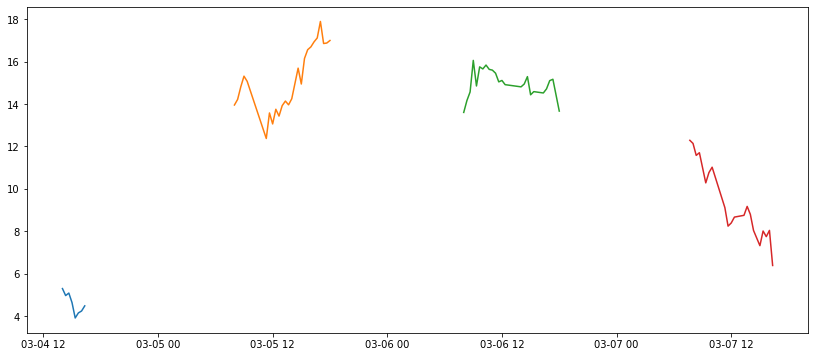

In [81]:
fig, ax = plt.subplots(figsize=(14, 6))
plt.plot(wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['ucm'])
plt.plot(wind_data_20min['2020-03-05 7:00':'2020-03-05 18:00']['ucm'])
plt.plot(wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['ucm'])
plt.plot(wind_data_20min['2020-03-07 6:00':'2020-03-07 18:00']['ucm'])

In [82]:
wind_data_20min = pd.concat([wind_data_20min['2020-03-04 14:40':'2020-03-04 18:00'],
                             wind_data_20min['2020-03-05 8:00':'2020-03-05 17:00'],
                             wind_data_20min['2020-03-06 8:00':'2020-03-06 17:00'],
                             wind_data_20min['2020-03-07 6:00':'2020-03-07 18:00']], axis=0,
                            join='outer')

In [83]:
wind_data_20min

,ucm,vcm,wcm
time,,,
2020-03-04 14:40:00,5.083742,7.031992e-15,1.887314e-15
2020-03-04 15:00:00,4.633596,1.021764e-15,-9.126198e-16
2020-03-04 15:20:00,3.908596,3.965608e-15,-4.319990e-15
2020-03-04 15:40:00,4.147173,-2.014332e-16,1.903666e-15
2020-03-04 16:00:00,4.237486,6.450598e-16,-3.558338e-16
...,...,...,...
2020-03-07 15:00:00,7.318852,-1.671458e-15,-4.876432e-16
2020-03-07 15:20:00,8.009256,1.307723e-14,-2.691040e-15
2020-03-07 15:40:00,7.743893,6.816534e-15,-3.173863e-15


In [84]:
wind_data_20min['W_total'] = wf[5:-3]
wind_data_20min['W_a'] = wf_20min_active_4l[4:] + wf_20min_active_5l + wf_20min_active_6l[1:] + wf_20min_active_7l[:-3]
wind_data_20min['W_a_right'] = wf_20min_active_4r[3:] + wf_20min_active_5r + wf_20min_active_6r + wf_20min_active_7r

In [85]:
wind_data_20min

,ucm,vcm,wcm,W_total,W_a,W_a_right
time,,,,,,
2020-03-04 14:40:00,5.083742,7.031992e-15,1.887314e-15,0.000355,0.000435,0.000428
2020-03-04 15:00:00,4.633596,1.021764e-15,-9.126198e-16,0.000146,0.000397,0.000564
2020-03-04 15:20:00,3.908596,3.965608e-15,-4.319990e-15,0.000078,0.000445,0.000452
2020-03-04 15:40:00,4.147173,-2.014332e-16,1.903666e-15,0.000152,0.000398,0.000421
2020-03-04 16:00:00,4.237486,6.450598e-16,-3.558338e-16,0.000247,0.000199,0.000228
...,...,...,...,...,...,...
2020-03-07 15:00:00,7.318852,-1.671458e-15,-4.876432e-16,0.002704,0.001002,0.000559
2020-03-07 15:20:00,8.009256,1.307723e-14,-2.691040e-15,0.000734,0.000604,0.000538
2020-03-07 15:40:00,7.743893,6.816534e-15,-3.173863e-15,0.002522,0.000664,0.000477


In [86]:
wind_data_20min = wind_data_20min.drop(index=wind_data_20min.loc[wind_data_20min['W_a'] > 0.004].index) 

(array([18325.5, 18326. , 18326.5, 18327. , 18327.5, 18328. , 18328.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

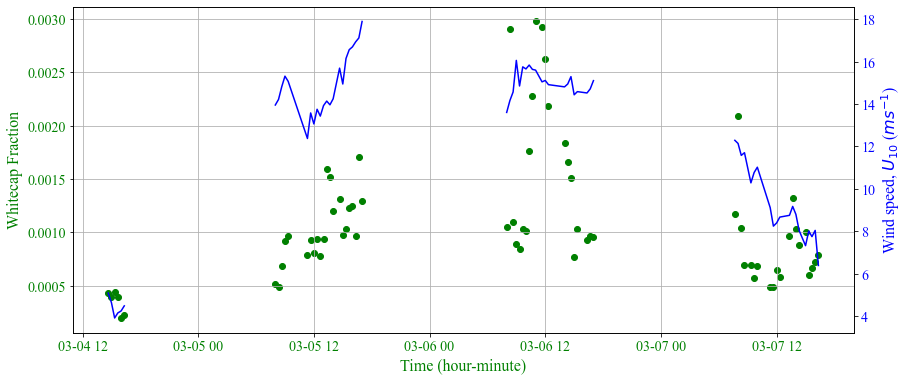

In [87]:
font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 16,
}

fig, ax = plt.subplots(figsize=(14, 6))

ax.scatter(wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00'].index,wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['W_a'], color = 'green')
ax.scatter(wind_data_20min['2020-03-05 6:00':'2020-03-05 18:00'].index,wind_data_20min['2020-03-05 6:00':'2020-03-05 18:00']['W_a'], color = 'green')
ax.scatter(wind_data_20min['2020-03-06 6:00':'2020-03-06 18:00'].index,wind_data_20min['2020-03-06 6:00':'2020-03-06 18:00']['W_a'], color = 'green')
ax.scatter(wind_data_20min['2020-03-07 6:00':'2020-03-07 18:00'].index,wind_data_20min['2020-03-07 6:00':'2020-03-07 18:00']['W_a'], color = 'green')



plt.grid()
plt.xlabel("Time (hour-minute)", font, color = 'green')
plt.ylabel("Whitecap Fraction", font, color = 'green')
plt.yticks(fontproperties = 'Times New Roman', size = 14, color = 'green')
plt.xticks(fontproperties = 'Times New Roman', size = 14, color = 'green')
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 16,
}

ax2 = ax.twinx()

ax2.plot(wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['ucm'], color = 'blue')
ax2.plot(wind_data_20min['2020-03-05 6:00':'2020-03-05 18:00']['ucm'], color = 'blue')
ax2.plot(wind_data_20min['2020-03-06 6:00':'2020-03-06 18:00']['ucm'], color = 'blue')
ax2.plot(wind_data_20min['2020-03-07 6:00':'2020-03-07 18:00']['ucm'], color = 'blue')


plt.xlabel("Time (hour-minute)", font, color = 'blue')
plt.ylabel("Wind speed, $U_{10}$ ($m s^{-1}$)", font, color = 'blue')
plt.yticks(fontproperties = 'Times New Roman', size = 14, color = 'blue')
plt.xticks(fontproperties = 'Times New Roman', size = 14, color = 'blue')
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# plt.savefig('E:/OneDrive - Texas A&M University/Code_sorted/wave_wind.jpg', bbox_inches = 'tight',dpi=300)

In [95]:
wind_data_20min

,ucm,vcm,wcm,W_total,W_a,W_a_right
time,,,,,,
2020-03-04 14:40:00,5.083742,7.031992e-15,1.887314e-15,0.000355,0.000435,0.000428
2020-03-04 15:00:00,4.633596,1.021764e-15,-9.126198e-16,0.000146,0.000397,0.000564
2020-03-04 15:20:00,3.908596,3.965608e-15,-4.319990e-15,0.000078,0.000445,0.000452
2020-03-04 15:40:00,4.147173,-2.014332e-16,1.903666e-15,0.000152,0.000398,0.000421
2020-03-04 16:00:00,4.237486,6.450598e-16,-3.558338e-16,0.000247,0.000199,0.000228
...,...,...,...,...,...,...
2020-03-07 15:00:00,7.318852,-1.671458e-15,-4.876432e-16,0.002704,0.001002,0.000559
2020-03-07 15:20:00,8.009256,1.307723e-14,-2.691040e-15,0.000734,0.000604,0.000538
2020-03-07 15:40:00,7.743893,6.816534e-15,-3.173863e-15,0.002522,0.000664,0.000477


In [88]:
w_a_3_4 = (wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['W_a']*100 
           + wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['W_a_right']*100)/2
w_a_3_5 = (wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['W_a']*100 
           + wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['W_a_right']*100)/2
w_a_3_6 = (wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['W_a']*100 
           + wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['W_a_right']*100)/2
w_a_3_7 = (wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['W_a']*100 
           + wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['W_a_right']*100)/2

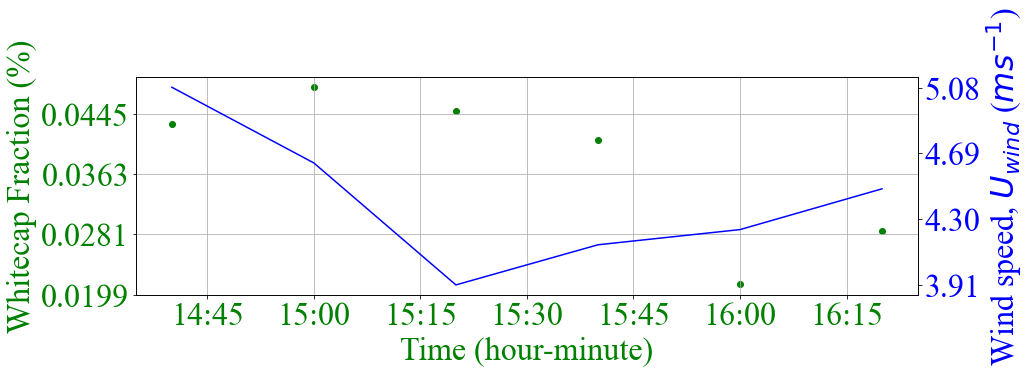

In [89]:
font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 32,
}

fig, ax = plt.subplots(figsize=(14, 4))

ax.scatter(wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00'].index,w_a_3_4, color = 'green')

y_tick1 = np.linspace(round(min(100*wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['W_a']), 4), 
                      round(max(100*wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['W_a']), 4), 4)

plt.grid()
plt.xlabel("Time (hour-minute)", font, color = 'green')
plt.ylabel("Whitecap Fraction (%)", font, color = 'green')
plt.yticks(y_tick1, fontproperties = 'Times New Roman', size = 32, color = 'green')
plt.xticks(fontproperties = 'Times New Roman', size = 32, color = 'green')
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 32,
}

ax2 = ax.twinx()

ax2.plot(wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['ucm'], color = 'blue')
y_tick2 = np.around(np.linspace(min(wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['ucm']), 
                      max(wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['ucm']), 4), decimals = 2)

plt.xlabel("Time (hour-minute)", font, color = 'blue')
plt.ylabel("Wind speed, $U_{wind}$ ($m s^{-1}$)", font, color = 'blue')
plt.yticks(y_tick2,fontproperties = 'Times New Roman', size = 32, color = 'blue')
plt.xticks(fontproperties = 'Times New Roman', size = 32, color = 'blue')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.savefig('E:/my-whitecaps/code/stats/w_wind_3_4.jpg', bbox_inches = 'tight',dpi=300)

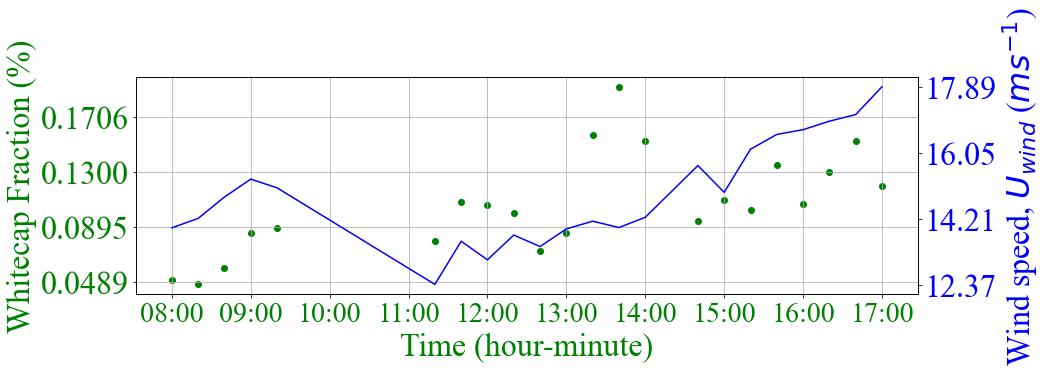

In [90]:
font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 32,
}

fig, ax = plt.subplots(figsize=(14, 4))


ax.scatter(wind_data_20min['2020-03-05 6:00':'2020-03-05 18:00'].index,w_a_3_5, color = 'green')

y_tick1 = np.linspace(round(100*min(wind_data_20min['2020-03-05 6:00':'2020-03-05 18:00']['W_a']), 4), 
                      round(100*max(wind_data_20min['2020-03-05 6:00':'2020-03-05 18:00']['W_a']), 4), 4)


plt.grid()
plt.xlabel("Time (hour-minute)", font, color = 'green')
plt.ylabel("Whitecap Fraction (%)", font, color = 'green')
plt.yticks(y_tick1, fontproperties = 'Times New Roman', size = 32, color = 'green')
plt.xticks(fontproperties = 'Times New Roman', size = 28, color = 'green')
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 32,
}

ax2 = ax.twinx()


ax2.plot(wind_data_20min['2020-03-05 6:00':'2020-03-05 18:00']['ucm'], color = 'blue')
y_tick2 = np.around(np.linspace(min(wind_data_20min['2020-03-05 6:00':'2020-03-05 18:00']['ucm']), 
                      max(wind_data_20min['2020-03-05 6:00':'2020-03-05 18:00']['ucm']), 4), decimals = 2)


plt.xlabel("Time (hour-minute)", font, color = 'blue')
plt.ylabel("Wind speed, $U_{wind}$ ($m s^{-1}$)", font, color = 'blue')
plt.yticks(y_tick2,fontproperties = 'Times New Roman', size = 32, color = 'blue')
plt.xticks(fontproperties = 'Times New Roman', size = 28, color = 'blue')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.savefig('E:/my-whitecaps/code/stats/w_wind_3_5.jpg', bbox_inches = 'tight',dpi=300)

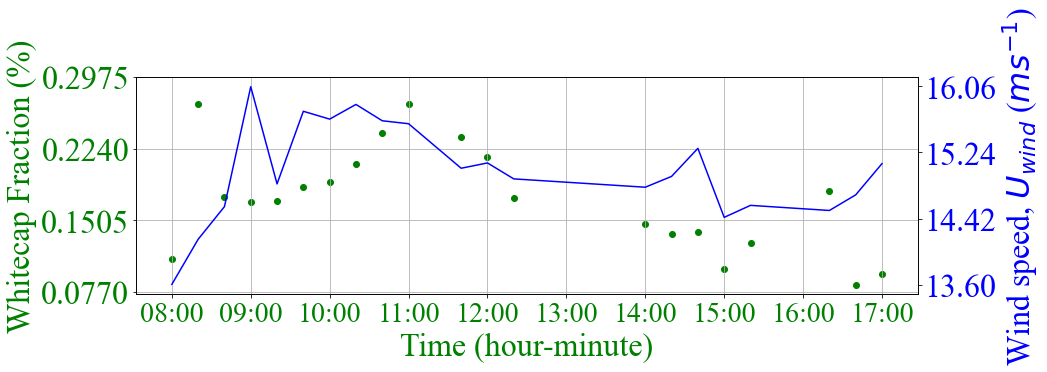

In [91]:
font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 32,
}

fig, ax = plt.subplots(figsize=(14, 4))


ax.scatter(wind_data_20min['2020-03-06 6:00':'2020-03-06 18:00'].index,w_a_3_6, color = 'green')
y_tick1 = np.linspace(round(100*min(wind_data_20min['2020-03-06 6:00':'2020-03-06 18:00']['W_a']), 4), 
                      round(100*max(wind_data_20min['2020-03-06 6:00':'2020-03-06 18:00']['W_a']), 4), 4)



plt.grid()
plt.xlabel("Time (hour-minute)", font, color = 'green')
plt.ylabel("Whitecap Fraction (%)", font, color = 'green')
plt.yticks(y_tick1, fontproperties = 'Times New Roman', size = 32, color = 'green')
plt.xticks(fontproperties = 'Times New Roman', size = 28, color = 'green')
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 32,
}

ax2 = ax.twinx()


ax2.plot(wind_data_20min['2020-03-06 6:00':'2020-03-06 18:00']['ucm'], color = 'blue')
y_tick2 = np.around(np.linspace(min(wind_data_20min['2020-03-06 6:00':'2020-03-06 18:00']['ucm']), 
                      max(wind_data_20min['2020-03-06 6:00':'2020-03-06 18:00']['ucm']), 4), decimals = 2)


plt.xlabel("Time (hour-minute)", font, color = 'blue')
plt.ylabel("Wind speed, $U_{wind}$ ($m s^{-1}$)", font, color = 'blue')
plt.yticks(y_tick2, fontproperties = 'Times New Roman', size = 32, color = 'blue')
plt.xticks(fontproperties = 'Times New Roman', size = 28, color = 'blue')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.savefig('E:/my-whitecaps/code/stats/w_wind_3_6.jpg', bbox_inches = 'tight',dpi=300)

In [96]:
wind_data_20min['2020-03-07 6:00':'2020-03-07 18:00'].index

DatetimeIndex(['2020-03-07 07:40:00', '2020-03-07 08:00:00',
               '2020-03-07 08:20:00', '2020-03-07 08:40:00',
               '2020-03-07 09:20:00', '2020-03-07 09:40:00',
               '2020-03-07 10:00:00', '2020-03-07 11:20:00',
               '2020-03-07 11:40:00', '2020-03-07 12:00:00',
               '2020-03-07 12:20:00', '2020-03-07 13:20:00',
               '2020-03-07 13:40:00', '2020-03-07 14:00:00',
               '2020-03-07 14:20:00', '2020-03-07 15:00:00',
               '2020-03-07 15:20:00', '2020-03-07 15:40:00',
               '2020-03-07 16:00:00', '2020-03-07 16:20:00'],
              dtype='datetime64[ns]', name='time', freq=None)

In [97]:
w_a_3_7

time
2020-03-07 08:00:00    0.154837
2020-03-07 08:20:00    0.103766
2020-03-07 08:40:00    0.088812
2020-03-07 09:20:00    0.070141
2020-03-07 09:40:00    0.068117
2020-03-07 10:00:00    0.081929
2020-03-07 11:20:00    0.063546
2020-03-07 11:40:00    0.060664
2020-03-07 12:00:00    0.058975
2020-03-07 12:20:00    0.079016
2020-03-07 13:20:00    0.092103
2020-03-07 13:40:00    0.105160
2020-03-07 14:00:00    0.085673
2020-03-07 14:20:00    0.063892
2020-03-07 15:00:00    0.078036
2020-03-07 15:20:00    0.057091
2020-03-07 15:40:00    0.057019
2020-03-07 16:00:00    0.052634
2020-03-07 16:20:00    0.068754
dtype: float64

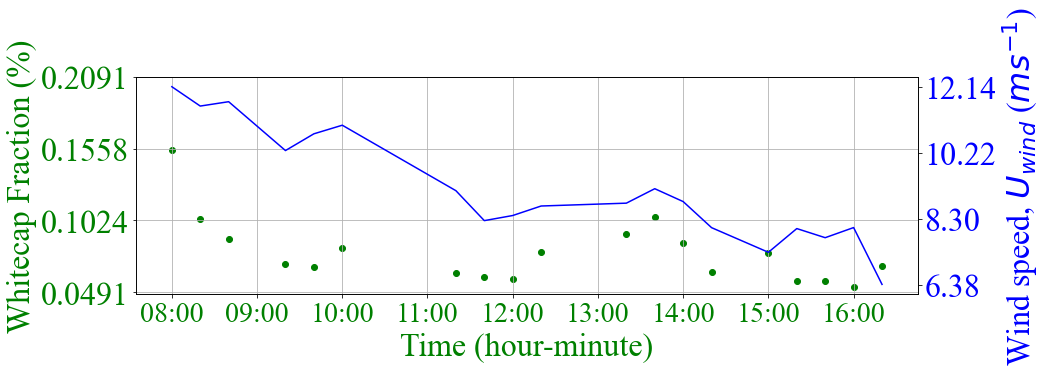

In [98]:
font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 32,
}

fig, ax = plt.subplots(figsize=(14, 4))

ax.scatter(wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00'].index,w_a_3_7, color = 'green')
y_tick1 = np.linspace(round(100*min(wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['W_a']), 4), 
                      round(100*max(wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['W_a']), 4), 4)


plt.grid()
plt.xlabel("Time (hour-minute)", font, color = 'green')
plt.ylabel("Whitecap Fraction (%)", font, color = 'green')
plt.yticks(y_tick1, fontproperties = 'Times New Roman', size = 32, color = 'green')
plt.xticks(fontproperties = 'Times New Roman', size = 28, color = 'green')
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 32,
}

ax2 = ax.twinx()


ax2.plot(wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['ucm'], color = 'blue')
y_tick2 = np.around(np.linspace(min(wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['ucm']), 
                      max(wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['ucm']), 4), decimals = 2)

plt.xlabel("Time (hour-minute)", font, color = 'blue')
plt.ylabel("Wind speed, $U_{wind}$ ($m s^{-1}$)", font, color = 'blue')
plt.yticks(y_tick2, fontproperties = 'Times New Roman', size = 32, color = 'blue')
plt.xticks(fontproperties = 'Times New Roman', size = 28, color = 'blue')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.savefig('E:/my-whitecaps/code/stats/w_wind_3_7.jpg', bbox_inches = 'tight',dpi=300)

# wave data and wind data

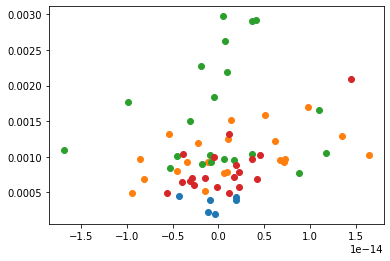

In [40]:
plt.scatter(wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['wcm'],
            wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['W_a'])
plt.scatter(wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['wcm'],
            wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['W_a'])
plt.scatter(wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['wcm'],
            wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['W_a'])
plt.scatter(wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['wcm'],
            wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['W_a'])

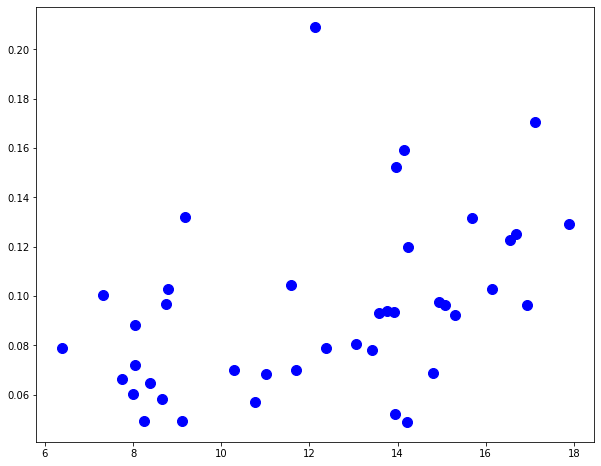

In [41]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
plt.scatter(np.sqrt(wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['ucm']**2 + wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['vcm']**2
            + wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['wcm']**2),
            wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['W_a']*100, color = 'blue',s=100)
plt.scatter(np.sqrt(wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['ucm']**2 + wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['vcm']**2
            + wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['wcm']**2),
            wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['W_a']*100, color = 'blue',s=100)


In [58]:
wind_data_20min

,ucm,vcm,wcm,W_total,W_a,W_a_right
time,,,,,,
2020-03-04 14:40:00,5.083742,7.031992e-15,1.887314e-15,0.000355,0.000435,0.000428
2020-03-04 15:00:00,4.633596,1.021764e-15,-9.126198e-16,0.000146,0.000397,0.000564
2020-03-04 15:20:00,3.908596,3.965608e-15,-4.319990e-15,0.000078,0.000445,0.000452
2020-03-04 15:40:00,4.147173,-2.014332e-16,1.903666e-15,0.000152,0.000398,0.000421
2020-03-04 16:00:00,4.237486,6.450598e-16,-3.558338e-16,0.000247,0.000199,0.000228
...,...,...,...,...,...,...
2020-03-07 15:00:00,7.318852,-1.671458e-15,-4.876432e-16,0.002704,0.001002,0.000559
2020-03-07 15:20:00,8.009256,1.307723e-14,-2.691040e-15,0.000734,0.000604,0.000538
2020-03-07 15:40:00,7.743893,6.816534e-15,-3.173863e-15,0.002522,0.000664,0.000477


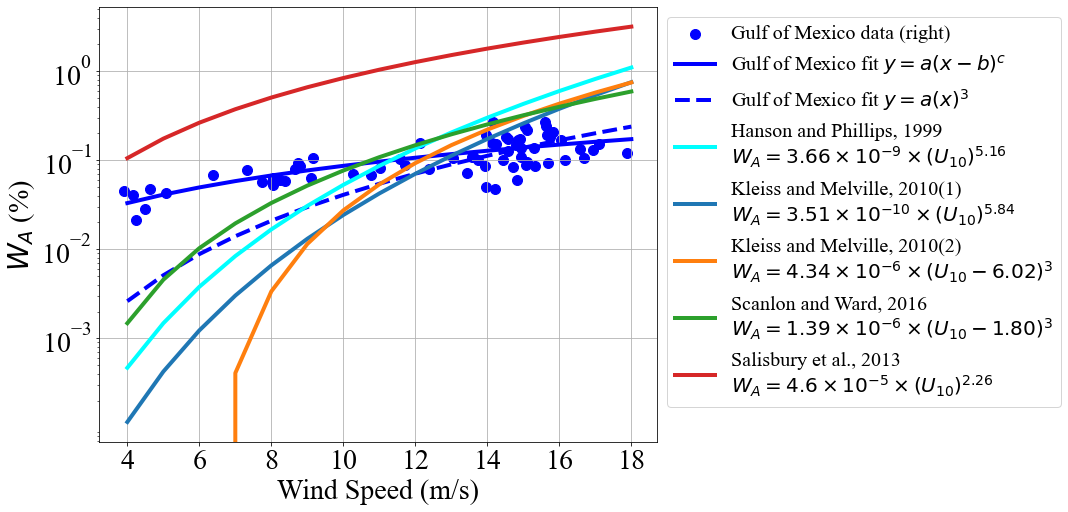

In [49]:
##### Take the average between the left and the right
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.set_yscale("log")

yticks = [0.001, 0.01, 0.1, 1]
font_legend = {'family' : 'Times New Roman', 
        'weight' : 'normal', 
        'size' : 28}

w_a_3_4 = (wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['W_a']*100 
           + wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['W_a_right']*100)/2
w_a_3_5 = (wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['W_a']*100 
           + wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['W_a_right']*100)/2
w_a_3_6 = (wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['W_a']*100 
           + wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['W_a_right']*100)/2
w_a_3_7 = (wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['W_a']*100 
           + wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['W_a_right']*100)/2

# plt.scatter(np.sqrt(wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['ucm']**2 + wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['vcm']**2
#             + wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['wcm']**2),
#             wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['W_a']*100, color = 'blue', label='Gulf of Mexico data (left)',s=100)
# plt.scatter(np.sqrt(wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['ucm']**2 + wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['vcm']**2
#             + wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['wcm']**2),
#             wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['W_a']*100, color = 'blue',s=100)
# plt.scatter(sqrt(wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['ucm']**2 + wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['vcm']**2
#             + wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['wcm']**2),
#             wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['W_a']*100, color = 'blue',s=100)
# plt.scatter(np.sqrt(wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['ucm']**2 + wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['vcm']**2
#             + wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['wcm']**2),
#             wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['W_a']*100, color = 'blue',s=100)

# plt.scatter(np.sqrt(wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['ucm']**2 + wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['vcm']**2
#             + wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['wcm']**2),
#             wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['W_a_right']*100, color = 'green', label='Gulf of Mexico data (right)',s=100)
# plt.scatter(np.sqrt(wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['ucm']**2 + wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['vcm']**2
#             + wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['wcm']**2),
#             wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['W_a_right']*100, color = 'green',s=100)
# plt.scatter(sqrt(wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['ucm']**2 + wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['vcm']**2
#             + wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['wcm']**2),
#             wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['W_a_right']*100, color = 'green',s=100)
# plt.scatter(np.sqrt(wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['ucm']**2 + wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['vcm']**2
#             + wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['wcm']**2),
#             wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['W_a_right']*100, color = 'green',s=100)

plt.scatter(np.sqrt(wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['ucm']**2 + wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['vcm']**2
            + wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['wcm']**2),
            w_a_3_4, color = 'blue', label='Gulf of Mexico data (right)',s=100)
plt.scatter(np.sqrt(wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['ucm']**2 + wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['vcm']**2
            + wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['wcm']**2),
            w_a_3_5, color = 'blue',s=100)
plt.scatter(sqrt(wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['ucm']**2 + wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['vcm']**2
            + wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['wcm']**2),
            w_a_3_6, color = 'blue',s=100)
plt.scatter(np.sqrt(wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['ucm']**2 + wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['vcm']**2
            + wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['wcm']**2),
            w_a_3_7, color = 'blue',s=100)

from matplotlib.lines import lineStyles
from scipy.optimize import curve_fit
x = wind_data_20min['ucm'].values

y = (wind_data_20min['W_a'].values + wind_data_20min['W_a_right'].values)/2

# 这里的函数可以自定义任意形式。
def func1(x, a, b,c):
    return a*(x - b)**c

# popt返回的是给定模型的最优参数。我们可以使用pcov的值检测拟合的质量，其对角线元素值代表着每个参数的方差。
popt1, pcov = curve_fit(func1, x, y)
a = popt1[0] 
b = popt1[1]
c = popt1[2]
xtemp = np.arange(4,19,1)
yvals = func1(xtemp,a,b,c) #拟合y值

plot2 = plt.plot(xtemp, yvals*100, 'blue',label='Gulf of Mexico fit $y=a(x-b)^{c}$',linewidth = 4)

residual = y - func1(x, a, b, c)
ss_res = np.sum(residual**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2 = 1 - (ss_res/ss_tot)
# 这里的函数可以自定义任意形式。
def func2(x, a):
    return a*(x)**3

# popt返回的是给定模型的最优参数。我们可以使用pcov的值检测拟合的质量，其对角线元素值代表着每个参数的方差。
popt2, pcov = curve_fit(func2, x, y)
a = popt2[0] 
xtemp = np.arange(4,19,1)
yvals = func2(xtemp,a) #拟合y值

residual = y - func2(x, a)
ss_res = np.sum(residual**2)
ss_tot = np.sum((y - np.mean(y))**2)

r22 = 1 - (ss_res/ss_tot)

plot3 = plt.plot(xtemp, yvals*100, 'blue',linestyle = '--',linewidth = 4, label='Gulf of Mexico fit $y=a(x)^{3}$')
ax.grid()

# Hanson and Phillips 1999
yyy1 = 3.66 * 10**(-9) * (xtemp)**5.16
# GOTEX Kleiss and Melville 2010
yyy2 = 3.51 * 10**(-10) * (xtemp)**5.84
yyy3 = 4.34 * 10**(-6) * (xtemp - 6.02)**3
# Scanlon and Ward 2015
yyy4 = 1.39 * 10**(-6) * (xtemp - 1.80)**3
# Salisbury 2013
yyy5 = 4.6 * 10**(-5) * (xtemp)**2.26

plot4 = plt.plot(xtemp, yyy1*100, linestyle = '-',linewidth = 4,
                 label='Hanson and Phillips, 1999' '\n' r'$W_{A}=3.66 \times 10^{-9} \times {(U_{10})^{5.16}}$',color='cyan')
plot5 = plt.plot(xtemp, yyy2*100, linestyle = '-',linewidth = 4, 
                 label='Kleiss and Melville, 2010(1)' '\n' r'$W_{A}=3.51 \times 10^{-10} \times {(U_{10})^{5.84}}$')
plot6 = plt.plot(xtemp, yyy3*100, linestyle = '-',linewidth = 4, 
                 label='Kleiss and Melville, 2010(2)' '\n' r'$W_{A}=4.34 \times 10^{-6} \times {(U_{10} - 6.02)^{3}}$')
plot7 = plt.plot(xtemp, yyy4*100, linestyle = '-',linewidth = 4, 
                 label='Scanlon and Ward, 2016' '\n' r'$W_{A}=1.39 \times 10^{-6} \times {(U_{10} - 1.80)^{3}}$')
plot8 = plt.plot(xtemp, yyy5*100, linestyle = '-',linewidth = 4, 
                 label='Salisbury et al., 2013' '\n' r'$W_{A}=4.6 \times 10^{-5} \times {(U_{10})^{2.26}}$')


ax.set_ylabel("$W_{A}$ (%)",font_legend)
ax.set_xlabel("Wind Speed (m/s)",font_legend)
plt.xticks(fontsize=28, fontproperties='Times New Roman')
plt.yticks(yticks, fontsize=28, fontproperties='Times New Roman')

font_legend1 = {'family' : 'Times New Roman', 
        'weight' : 'normal', 
        'size' : 20}

plt.legend(prop = font_legend1,  
         bbox_to_anchor = (1, 1))
plt.savefig('average_left_right.png', bbox_inches = 'tight')

In [47]:
r2

0.41630331616299865

In [48]:
r22

0.14130280823004382

In [50]:
popt1

array([ 3.55642862e-05, -1.50544553e+00,  1.30656239e+00])

In [52]:
popt2

array([4.08817825e-07])

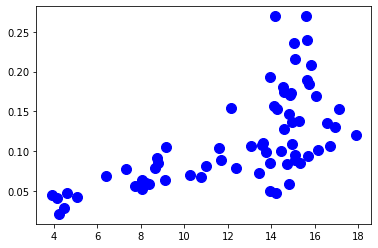

In [51]:
plt.scatter(np.sqrt(wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['ucm']**2 + wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['vcm']**2
            + wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['wcm']**2),
            w_a_3_4, color = 'blue', label='Gulf of Mexico data (right)',s=100)
plt.scatter(np.sqrt(wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['ucm']**2 + wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['vcm']**2
            + wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['wcm']**2),
            w_a_3_5, color = 'blue',s=100)
plt.scatter(sqrt(wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['ucm']**2 + wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['vcm']**2
            + wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['wcm']**2),
            w_a_3_6, color = 'blue',s=100)
plt.scatter(np.sqrt(wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['ucm']**2 + wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['vcm']**2
            + wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['wcm']**2),
            w_a_3_7, color = 'blue',s=100)

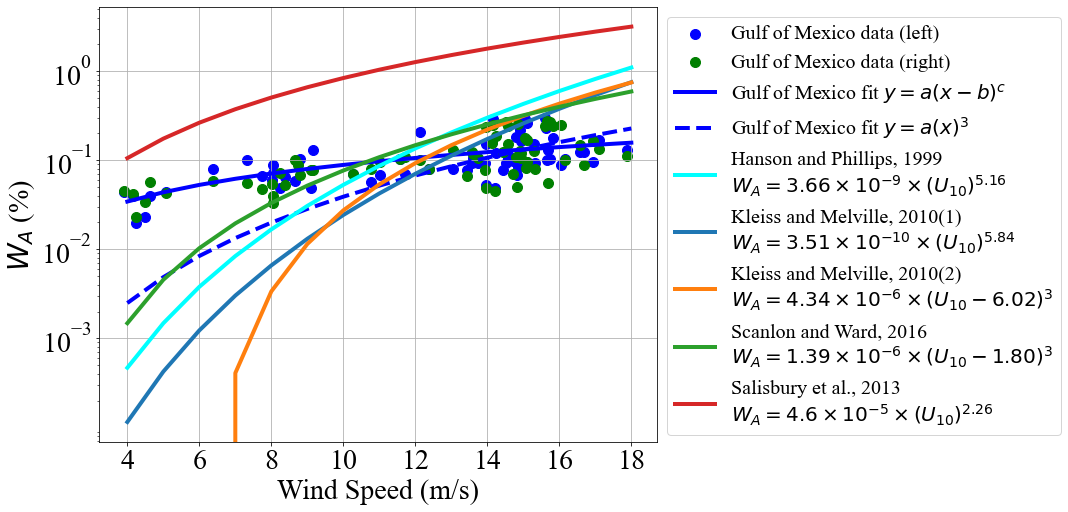

In [43]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.set_yscale("log")

yticks = [0.001, 0.01, 0.1, 1]
font_legend = {'family' : 'Times New Roman', 
        'weight' : 'normal', 
        'size' : 28}


plt.scatter(np.sqrt(wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['ucm']**2 + wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['vcm']**2
            + wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['wcm']**2),
            wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['W_a']*100, color = 'blue', label='Gulf of Mexico data (left)',s=100)
plt.scatter(np.sqrt(wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['ucm']**2 + wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['vcm']**2
            + wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['wcm']**2),
            wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['W_a']*100, color = 'blue',s=100)
plt.scatter(sqrt(wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['ucm']**2 + wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['vcm']**2
            + wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['wcm']**2),
            wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['W_a']*100, color = 'blue',s=100)
plt.scatter(np.sqrt(wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['ucm']**2 + wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['vcm']**2
            + wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['wcm']**2),
            wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['W_a']*100, color = 'blue',s=100)

plt.scatter(np.sqrt(wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['ucm']**2 + wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['vcm']**2
            + wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['wcm']**2),
            wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['W_a_right']*100, color = 'green', label='Gulf of Mexico data (right)',s=100)
plt.scatter(np.sqrt(wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['ucm']**2 + wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['vcm']**2
            + wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['wcm']**2),
            wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['W_a_right']*100, color = 'green',s=100)
plt.scatter(sqrt(wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['ucm']**2 + wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['vcm']**2
            + wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['wcm']**2),
            wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['W_a_right']*100, color = 'green',s=100)
plt.scatter(np.sqrt(wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['ucm']**2 + wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['vcm']**2
            + wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['wcm']**2),
            wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['W_a_right']*100, color = 'green',s=100)


from matplotlib.lines import lineStyles
from scipy.optimize import curve_fit
x = wind_data_20min['ucm'].values

y = wind_data_20min['W_a'].values

# 这里的函数可以自定义任意形式。
def func1(x, a, b,c):
    return a*(x - b)**c

# popt返回的是给定模型的最优参数。我们可以使用pcov的值检测拟合的质量，其对角线元素值代表着每个参数的方差。
popt1, pcov = curve_fit(func1, x, y)
a = popt1[0] 
b = popt1[1]
c = popt1[2]
xtemp = np.arange(4,19,1)
yvals = func1(xtemp,a,b,c) #拟合y值

plot2 = plt.plot(xtemp, yvals*100, 'blue',label='Gulf of Mexico fit $y=a(x-b)^{c}$',linewidth = 4)

residual = y - func1(x, a, b, c)
ss_res = np.sum(residual**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2 = 1 - (ss_res/ss_tot)
# 这里的函数可以自定义任意形式。
def func2(x, a):
    return a*(x)**3

# popt返回的是给定模型的最优参数。我们可以使用pcov的值检测拟合的质量，其对角线元素值代表着每个参数的方差。
popt2, pcov = curve_fit(func2, x, y)
a = popt2[0] 
xtemp = np.arange(4,19,1)
yvals = func2(xtemp,a) #拟合y值

residual = y - func2(x, a)
ss_res = np.sum(residual**2)
ss_tot = np.sum((y - np.mean(y))**2)

r22 = 1 - (ss_res/ss_tot)

plot3 = plt.plot(xtemp, yvals*100, 'blue',linestyle = '--',linewidth = 4, label='Gulf of Mexico fit $y=a(x)^{3}$')
ax.grid()

# Hanson and Phillips 1999
yyy1 = 3.66 * 10**(-9) * (xtemp)**5.16
# GOTEX Kleiss and Melville 2010
yyy2 = 3.51 * 10**(-10) * (xtemp)**5.84
yyy3 = 4.34 * 10**(-6) * (xtemp - 6.02)**3
# Scanlon and Ward 2015
yyy4 = 1.39 * 10**(-6) * (xtemp - 1.80)**3
# Salisbury 2013
yyy5 = 4.6 * 10**(-5) * (xtemp)**2.26

plot4 = plt.plot(xtemp, yyy1*100, linestyle = '-',linewidth = 4,
                 label='Hanson and Phillips, 1999' '\n' r'$W_{A}=3.66 \times 10^{-9} \times {(U_{10})^{5.16}}$',color='cyan')
plot5 = plt.plot(xtemp, yyy2*100, linestyle = '-',linewidth = 4, 
                 label='Kleiss and Melville, 2010(1)' '\n' r'$W_{A}=3.51 \times 10^{-10} \times {(U_{10})^{5.84}}$')
plot6 = plt.plot(xtemp, yyy3*100, linestyle = '-',linewidth = 4, 
                 label='Kleiss and Melville, 2010(2)' '\n' r'$W_{A}=4.34 \times 10^{-6} \times {(U_{10} - 6.02)^{3}}$')
plot7 = plt.plot(xtemp, yyy4*100, linestyle = '-',linewidth = 4, 
                 label='Scanlon and Ward, 2016' '\n' r'$W_{A}=1.39 \times 10^{-6} \times {(U_{10} - 1.80)^{3}}$')
plot8 = plt.plot(xtemp, yyy5*100, linestyle = '-',linewidth = 4, 
                 label='Salisbury et al., 2013' '\n' r'$W_{A}=4.6 \times 10^{-5} \times {(U_{10})^{2.26}}$')


ax.set_ylabel("$W_{A}$ (%)",font_legend)
ax.set_xlabel("Wind Speed (m/s)",font_legend)
plt.xticks(fontsize=28, fontproperties='Times New Roman')
plt.yticks(yticks, fontsize=28, fontproperties='Times New Roman')

font_legend1 = {'family' : 'Times New Roman', 
        'weight' : 'normal', 
        'size' : 20}

plt.legend(prop = font_legend1,  
         bbox_to_anchor = (1, 1))
plt.savefig('2222.png', bbox_inches = 'tight')

In [103]:
r2

0.2793116769677093

In [104]:
r22

-0.026243453122176907

In [105]:
popt1

array([2.22623151e-04, 2.41984865e+00, 7.12864258e-01])

In [106]:
popt2

array([3.99093447e-07])

In [99]:
wind_data_20min.to_csv('wind_wf_20min.csv')

In [100]:
wind_data_20min

,ucm,vcm,wcm,W_total,W_a,W_a_right
time,,,,,,
2020-03-04 14:40:00,5.083742,7.031992e-15,1.887314e-15,0.000355,0.000435,0.000428
2020-03-04 15:00:00,4.633596,1.021764e-15,-9.126198e-16,0.000146,0.000397,0.000564
2020-03-04 15:20:00,3.908596,3.965608e-15,-4.319990e-15,0.000078,0.000445,0.000452
2020-03-04 15:40:00,4.147173,-2.014332e-16,1.903666e-15,0.000152,0.000398,0.000421
2020-03-04 16:00:00,4.237486,6.450598e-16,-3.558338e-16,0.000247,0.000199,0.000228
...,...,...,...,...,...,...
2020-03-07 15:00:00,7.318852,-1.671458e-15,-4.876432e-16,0.002704,0.001002,0.000559
2020-03-07 15:20:00,8.009256,1.307723e-14,-2.691040e-15,0.000734,0.000604,0.000538
2020-03-07 15:40:00,7.743893,6.816534e-15,-3.173863e-15,0.002522,0.000664,0.000477


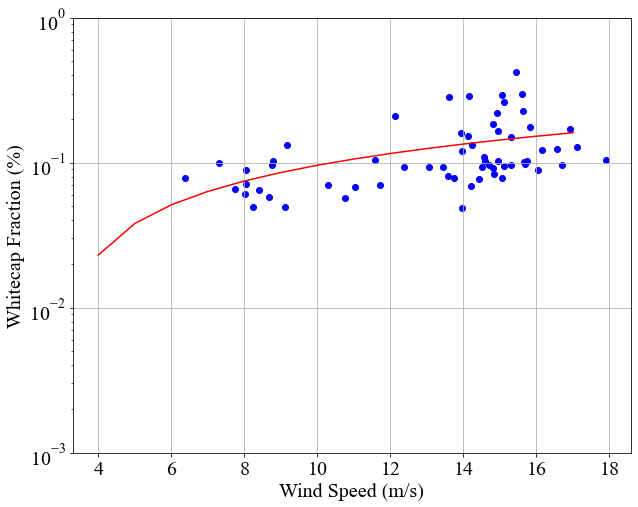

In [118]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.set_yscale("log")

yticks = [0.001, 0.01, 0.1, 1]
font_legend = {'family' : 'Times New Roman', 
        'weight' : 'normal', 
        'size' : 20}



plt.scatter(np.sqrt(wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['ucm']**2 + wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['vcm']**2
            + wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['wcm']**2),
            wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['W_a']*100, color = 'blue')
plt.scatter(sqrt(wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['ucm']**2 + wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['vcm']**2
            + wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['wcm']**2),
            wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['W_a']*100, color = 'blue')
plt.scatter(np.sqrt(wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['ucm']**2 + wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['vcm']**2
            + wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['wcm']**2),
            wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['W_a']*100, color = 'blue')

from scipy.optimize import curve_fit
x = wind_data_20min['ucm'].values
x = x[9:]
y = wind_data_20min['W_a'].values
y = y[9:]
# 这里的函数可以自定义任意形式。
def func(x, a, b,c):
    return a*(x - b)**c

# popt返回的是给定模型的最优参数。我们可以使用pcov的值检测拟合的质量，其对角线元素值代表着每个参数的方差。
popt, pcov = curve_fit(func, x, y)
a = popt[0] 
b = popt[1]
c = popt[2]
xtemp = np.arange(4,18,1)
yvals = func(xtemp,a,b,c) #拟合y值

plot2 = plt.plot(xtemp, yvals*100, 'r',label='polyfit values')

ax.grid()

ax.set_ylabel("Whitecap Fraction (%)",font_legend)
ax.set_xlabel("Wind Speed (m/s)",font_legend)
plt.xticks(fontsize=20, fontproperties='Times New Roman')
plt.yticks(yticks, fontsize=20, fontproperties='Times New Roman')
plt.savefig('2222.png', bbox_inches = 'tight')

In [122]:
func(0,a,b,c)

2.061410378124303e-05

In [119]:
popt

array([2.21950073e-04, 2.94804777e+00, 7.49648499e-01])

In [53]:
wind_data_20min.to_csv('wind_wf_20min.csv')

In [170]:
wind_data_20min

,ucm,vcm,wcm,W_total,W_a
time,,,,,
2020-03-04 14:00:00,5.295121,-2.690385e-15,-2.601899e-15,0.000671,0.001443
2020-03-04 14:20:00,4.965126,-5.700150e-15,3.023510e-15,0.001091,0.000435
2020-03-04 14:40:00,5.083742,7.031992e-15,1.887314e-15,0.000355,0.000397
2020-03-04 15:00:00,4.633596,1.021764e-15,-9.126198e-16,0.000146,0.000445
2020-03-04 15:20:00,3.908596,3.965608e-15,-4.319990e-15,0.000078,0.000398
...,...,...,...,...,...
2020-03-07 15:00:00,7.318852,-1.671458e-15,-4.876432e-16,0.002704,0.001002
2020-03-07 15:20:00,8.009256,1.307723e-14,-2.691040e-15,0.000734,0.000604
2020-03-07 15:40:00,7.743893,6.816534e-15,-3.173863e-15,0.002522,0.000664


In [171]:
sst_20min = pd.read_csv('E:\OneDrive - Texas A&M University\Buoy Data near Cruise/WindsByScott_sst_20min.csv',
                   sep=' ',names=['sst'],header=None)
airt_20min = pd.read_csv('E:\OneDrive - Texas A&M University\Buoy Data near Cruise/WindsByScott_airT_20min.csv',
                   sep=' ',names=['airT'],header=None)

In [175]:
wind_data_20min['sst'] = np.squeeze(sst_20min.values)
wind_data_20min['airT'] = np.squeeze(airt_20min.values)

In [177]:
wind_data_20min
wind_data_20min.to_csv('wind_wf_20min.csv')

In [178]:
wind_data_20min

,ucm,vcm,wcm,W_total,W_a,sst,airT
time,,,,,,,
2020-03-04 14:00:00,5.295121,-2.690385e-15,-2.601899e-15,0.000671,0.001443,20.113321,24.619853
2020-03-04 14:20:00,4.965126,-5.700150e-15,3.023510e-15,0.001091,0.000435,19.968599,24.428715
2020-03-04 14:40:00,5.083742,7.031992e-15,1.887314e-15,0.000355,0.000397,19.884207,24.261341
2020-03-04 15:00:00,4.633596,1.021764e-15,-9.126198e-16,0.000146,0.000445,19.882076,24.266013
2020-03-04 15:20:00,3.908596,3.965608e-15,-4.319990e-15,0.000078,0.000398,19.947724,24.185861
...,...,...,...,...,...,...,...
2020-03-07 15:00:00,7.318852,-1.671458e-15,-4.876432e-16,0.002704,0.001002,23.496694,19.564045
2020-03-07 15:20:00,8.009256,1.307723e-14,-2.691040e-15,0.000734,0.000604,23.486424,19.614431
2020-03-07 15:40:00,7.743893,6.816534e-15,-3.173863e-15,0.002522,0.000664,23.448058,19.575404


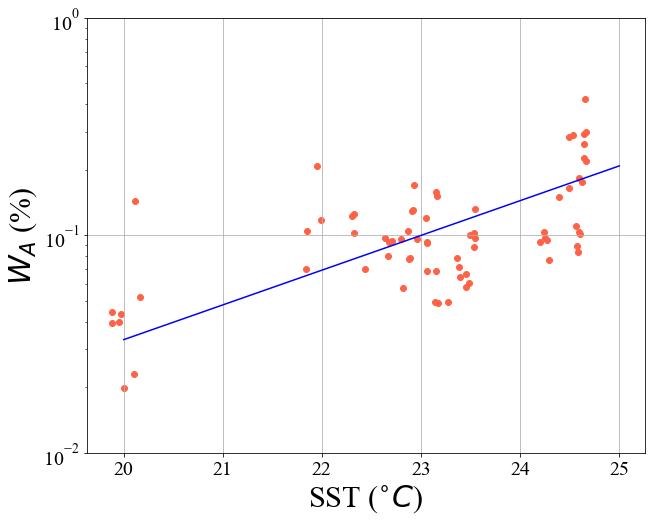

In [293]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.set_yscale("log")

yticks = [ 0.01, 0.1, 1]
font_legend = {'family' : 'Times New Roman', 
        'weight' : 'normal', 
        'size' : 30}

from matplotlib.lines import lineStyles
from scipy.optimize import curve_fit
x = wind_data_20min['sst'].values

y = wind_data_20min['W_a'].values

# 这里的函数可以自定义任意形式。
def func(x, a, b):
    return a*exp(b*x)

# popt返回的是给定模型的最优参数。我们可以使用pcov的值检测拟合的质量，其对角线元素值代表着每个参数的方差。
popt, pcov = curve_fit(func, x, y)
a = popt[0] 
b = popt[1]

xtemp = np.arange(20,26,1)
yvals = func(xtemp,a,b) #拟合y值

residual = y - func(x, a, b)
ss_res = np.sum(residual**2)
ss_tot = np.sum((y-np.mean(y))**2)
r2 = 1 - (ss_res/ss_tot)

plt.scatter(wind_data_20min['sst'], wind_data_20min['W_a']*100, color='tomato')

plot2 = plt.plot(xtemp, yvals*100, 'blue',label='Gulf of Mexico fit $y=a(x-b)^{c}$')
ax.grid()

ax.set_ylabel("$W_{A}$ (%)",font_legend)
ax.set_xlabel("SST ($^{\circ}C$)",font_legend)
plt.xticks(fontsize=20, fontproperties='Times New Roman')
plt.yticks(yticks, fontsize=20, fontproperties='Times New Roman')
plt.savefig('sst.png', bbox_inches = 'tight')

In [250]:
r2

0.3297268458556615

In [294]:
popt

array([2.10798601e-07, 3.68020097e-01])

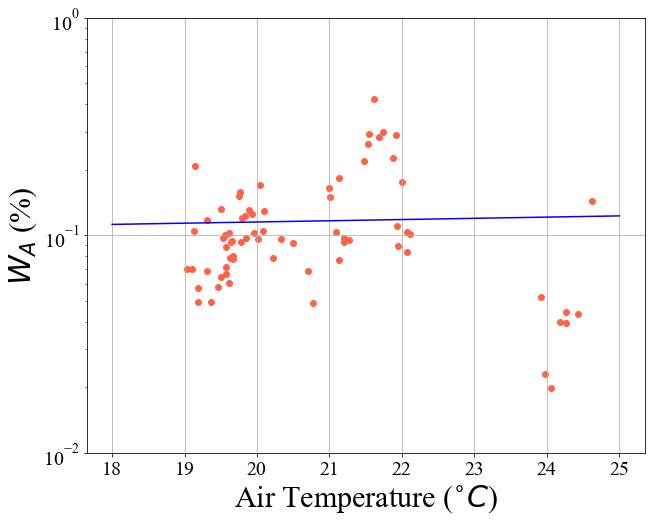

In [295]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.set_yscale("log")

yticks = [ 0.01, 0.1, 1]
font_legend = {'family' : 'Times New Roman', 
        'weight' : 'normal', 
        'size' : 30}

from matplotlib.lines import lineStyles
from scipy.optimize import curve_fit
x = wind_data_20min['airT'].values

y = wind_data_20min['W_a'].values

# 这里的函数可以自定义任意形式。
def func(x, a, b):
    return a*exp(b*x)

# popt返回的是给定模型的最优参数。我们可以使用pcov的值检测拟合的质量，其对角线元素值代表着每个参数的方差。
popt, pcov = curve_fit(func, x, y)
a = popt[0] 
b = popt[1]

xtemp = np.arange(18,26,1)
yvals = func(xtemp,a,b) #拟合y值
residual = y - func(x, a, b)
ss_res = np.sum(residual**2)
ss_tot = np.sum((y-np.mean(y))**2)
r2 = 1 - (ss_res/ss_tot)


plt.scatter(wind_data_20min['airT'], wind_data_20min['W_a']*100, color='tomato')

plot2 = plt.plot(xtemp, yvals*100, 'blue',label='Gulf of Mexico fit $y=a(x-b)^{c}$')
ax.grid()

ax.set_ylabel("$W_{A}$ (%)",font_legend)
ax.set_xlabel("Air Temperature ($^{\circ}C$)",font_legend)
plt.xticks(fontsize=20, fontproperties='Times New Roman')
plt.yticks(yticks, fontsize=20, fontproperties='Times New Roman')
plt.savefig('airtemp.png', bbox_inches = 'tight')

In [260]:
r2

0.0013155883819221392

In [296]:
popt

array([0.00089066, 0.01287582])

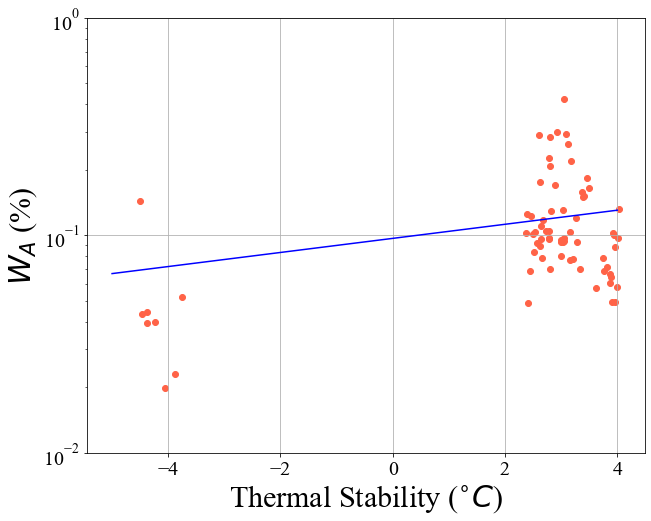

In [297]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.set_yscale("log")

yticks = [ 0.01, 0.1, 1]
font_legend = {'family' : 'Times New Roman', 
        'weight' : 'normal', 
        'size' : 30}

from matplotlib.lines import lineStyles
from scipy.optimize import curve_fit
x = wind_data_20min['sst'].values - wind_data_20min['airT'].values

y = wind_data_20min['W_a'].values

# 这里的函数可以自定义任意形式。
def func(x, a, b):
    return a*exp(b*x)

# popt返回的是给定模型的最优参数。我们可以使用pcov的值检测拟合的质量，其对角线元素值代表着每个参数的方差。
popt, pcov = curve_fit(func, x, y)
a = popt[0] 
b = popt[1]

xtemp = np.arange(-5,5,1)
yvals = func(xtemp,a,b) #拟合y值
residual = y - func(x, a, b)
ss_res = np.sum(residual**2)
ss_tot = np.sum((y-np.mean(y))**2)
r2 = 1 - (ss_res/ss_tot)


plt.scatter(wind_data_20min['sst'] - wind_data_20min['airT'], wind_data_20min['W_a']*100, color='tomato')

plot2 = plt.plot(xtemp, yvals*100, 'blue',label='Gulf of Mexico fit $y=a(x-b)^{c}$')
ax.grid()

ax.set_ylabel("$W_{A}$ (%)",font_legend)
ax.set_xlabel("Thermal Stability ($^{\circ}C$)",font_legend)
plt.xticks(fontsize=20, fontproperties='Times New Roman')
plt.yticks(yticks, fontsize=20, fontproperties='Times New Roman')
plt.savefig('thermal.png', bbox_inches = 'tight')

In [298]:
r2

0.06269239936015691

In [299]:
popt

array([0.00096862, 0.07459186])

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.set_yscale("log")

yticks = [0.001, 0.01, 0.1, 1]
font_legend = {'family' : 'Times New Roman', 
        'weight' : 'normal', 
        'size' : 30}


plt.scatter(np.sqrt(wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['ucm']**2 + wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['vcm']**2
            + wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['wcm']**2),
            wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['W_a']*100, color = 'tomato', label='Gulf of Mexico data')
plt.scatter(np.sqrt(wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['ucm']**2 + wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['vcm']**2
            + wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['wcm']**2),
            wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['W_a']*100, color = 'tomato')
plt.scatter(sqrt(wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['ucm']**2 + wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['vcm']**2
            + wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['wcm']**2),
            wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['W_a']*100, color = 'tomato')
plt.scatter(np.sqrt(wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['ucm']**2 + wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['vcm']**2
            + wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['wcm']**2),
            wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['W_a']*100, color = 'tomato')

from matplotlib.lines import lineStyles
from scipy.optimize import curve_fit
x = wind_data_20min['ucm'].values

y = wind_data_20min['W_a'].values

# 这里的函数可以自定义任意形式。
def func(x, a, b,c):
    return a*(x - b)**c

# popt返回的是给定模型的最优参数。我们可以使用pcov的值检测拟合的质量，其对角线元素值代表着每个参数的方差。
popt, pcov = curve_fit(func, x, y)
a = popt[0] 
b = popt[1]
c = popt[2]
xtemp = np.arange(4,19,1)
yvals = func(xtemp,a,b,c) #拟合y值

plot2 = plt.plot(xtemp, yvals*100, 'cyan',label='Gulf of Mexico fit $y=a(x-b)^{c}$')

# 这里的函数可以自定义任意形式。
def func(x, a, b):
    return a*(x - b)**3

# popt返回的是给定模型的最优参数。我们可以使用pcov的值检测拟合的质量，其对角线元素值代表着每个参数的方差。
popt, pcov = curve_fit(func, x, y)
a = popt[0] 
b = popt[1]
xtemp = np.arange(4,19,1)
yvals = func(xtemp,a,b) #拟合y值

plot3 = plt.plot(xtemp, yvals*100, 'blue',linestyle = '--',linewidth = 4, label='Gulf of Mexico fit $y=a(x-b)^{2}$')
ax.grid()

# Hanson and Phillips 1999
yyy1 = 3.66 * 10**(-9) * (xtemp)**5.16
# GOTEX Kleiss and Melville 2010
yyy2 = 3.51 * 10**(-10) * (xtemp)**5.84
yyy3 = 4.34 * 10**(-6) * (xtemp - 6.02)**3
# Scanlon and Ward 2015
yyy4 = 1.39 * 10**(-6) * (xtemp - 1.80)**3
# Salisbury 2013
yyy5 = 4.6 * 10**(-5) * (xtemp)**2.26

plot4 = plt.plot(xtemp, yyy1*100, linestyle = '-',linewidth = 4, label='Hanson and Phillips, 1999')
plot5 = plt.plot(xtemp, yyy2*100, linestyle = '-',linewidth = 4, label='Kleiss and Melville, 2010(1)')
plot6 = plt.plot(xtemp, yyy3*100, linestyle = '-',linewidth = 4, label='Kleiss and Melville, 2010(2)')
plot7 = plt.plot(xtemp, yyy4*100, linestyle = '-',linewidth = 4, label='Scanlon and Ward, 2015')
plot8 = plt.plot(xtemp, yyy5*100, linestyle = '-',linewidth = 4, label='Salisbury et al., 2013')


ax.set_ylabel("$W_{A}$ (%)",font_legend)
ax.set_xlabel("$U_{10}$ (m/s)",font_legend)
plt.xticks(fontsize=30, fontproperties='Times New Roman')
plt.yticks(yticks, fontsize=30, fontproperties='Times New Roman')

font_legend1 = {'family' : 'Times New Roman', 
        'weight' : 'normal', 
        'size' : 16}

plt.legend(prop = font_legend1)
plt.savefig('3333.png', bbox_inches = 'tight')

# Plot For Paper

## Functions

## Plot

In [127]:
def get_ROI(img):
    """_summary_

    Args:
        img (_type_): _description_
    """
    nv = np.shape(img)[0]
    nu = np.shape(img)[1]
    
    # detect the horizon in the image
    (line, rho, theta) = Horizon_tracking(img)
    
    # determine the region of interest according to the horizon
    uplimit = int((nv - max(line[:, 0]))/4 + max(line[:, 0]))
    bottomlimit = nv - int(nv/10)
    
    return uplimit, bottomlimit, line, rho, theta

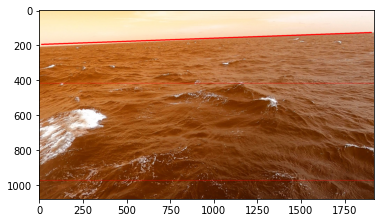

In [137]:
import cv2

# read in the image
img = cv2.imread("E:/GoPro_deep/image/GH010009.MP4/original_frame242.jpg")
aaa, bbb, ccc, rho, theta = get_ROI(img)
img[aaa, :] = [255, 0, 0]
img[aaa+1, :] = [255, 0, 0]
img[bbb, :] = [255, 0, 0]
img[bbb+1, :] = [255, 0, 0]
cv2.line(img, (ccc[0,1], ccc[0,0]), (ccc[-1,1], ccc[-1,0]), 255, 6)
plt.imshow(img)

In [136]:
ccc[1,1]

1906

In [130]:
ccc

array([[ 128, 1905],
       [ 128, 1906],
       [ 128, 1907],
       ...,
       [ 196,   12],
       [ 196,   13],
       [ 196,   14]], dtype=int64)

# Spectrum Analysis

In [72]:
wind_time = pd.read_csv('E:\OneDrive - Texas A&M University\Buoy Data near Cruise/WindsByScott_time.csv',
                        sep=' ',names=['time'],header=None)
data = pd.read_csv('E:\OneDrive - Texas A&M University\Buoy Data near Cruise/WindsByScott_10hz.csv',
                   sep=' ',names=['uc', 'vc', 'wc'],header=None)
wind_time.apply(pd.to_datetime, axis==0)
wind_data = pd.concat([wind_time, data], axis=1)

wind_data['time'] = pd.to_datetime(wind_data['time'])
wind_data = wind_data.set_index('time')
wind_data

,uc,vc,wc
time,,,
2020-03-04 14:02:08.100,4.925037,-1.859924,1.561179
2020-03-04 14:02:08.200,5.528047,-1.923758,1.584634
2020-03-04 14:02:08.300,6.126599,-1.953701,1.590702
2020-03-04 14:02:08.400,6.717620,-1.949854,1.579901
2020-03-04 14:02:08.500,7.139373,-1.870966,1.528747
...,...,...,...
2020-03-07 16:39:59.600,5.222269,-0.252898,0.143343
2020-03-07 16:39:59.700,5.205064,-0.215021,0.080588
2020-03-07 16:39:59.800,5.151119,-0.176155,0.182312


In [74]:
wind_data['2020-03-04 15:00':'2020-03-04 15:19']

,uc,vc,wc
time,,,
2020-03-04 15:00:00.000,10.602888,1.807093,-0.265745
2020-03-04 15:00:00.100,10.336413,0.996105,-0.533315
2020-03-04 15:00:00.200,9.929599,0.919575,-0.383113
2020-03-04 15:00:00.300,9.445096,0.839224,-0.186119
2020-03-04 15:00:00.400,9.309042,0.792189,-0.243585
...,...,...,...
2020-03-04 15:19:59.500,8.612787,3.024508,-0.774647
2020-03-04 15:19:59.600,9.045706,-0.105467,-0.788406
2020-03-04 15:19:59.700,8.974359,-0.071195,-0.814857


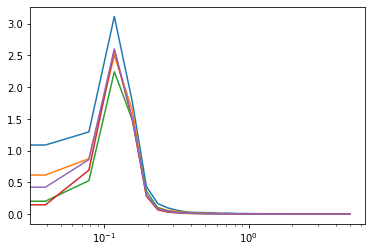

In [76]:
from scipy import signal

freqs1, psd1 = signal.welch(wind_data['2020-03-04 15:00':'2020-03-04 15:19']['wc'].values, fs=10)
freqs2, psd2 = signal.welch(wind_data['2020-03-04 15:20':'2020-03-04 15:39']['wc'].values, fs=10)
freqs3, psd3 = signal.welch(wind_data['2020-03-04 15:40':'2020-03-04 15:59']['wc'].values, fs=10)
freqs4, psd4 = signal.welch(wind_data['2020-03-04 16:00':'2020-03-04 16:19']['wc'].values, fs=10)
freqs5, psd5 = signal.welch(wind_data['2020-03-04 16:20':'2020-03-04 16:39']['wc'].values, fs=10)
plt.semilogx(freqs1, psd1)
plt.semilogx(freqs2, psd2)
plt.semilogx(freqs3, psd3)
plt.semilogx(freqs4, psd4)
plt.semilogx(freqs5, psd5)

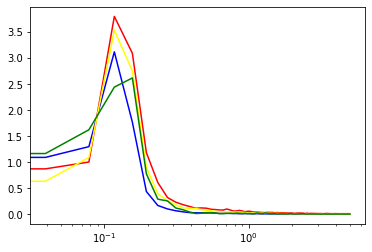

In [79]:
freqs1, psd1 = signal.welch(wind_data['2020-03-04 15:00':'2020-03-04 15:19']['wc'].values, fs=10)
freqs2, psd2 = signal.welch(wind_data['2020-03-05 15:00':'2020-03-05 15:19']['wc'].values, fs=10)
freqs3, psd3 = signal.welch(wind_data['2020-03-06 15:00':'2020-03-06 15:19']['wc'].values, fs=10)
freqs4, psd4 = signal.welch(wind_data['2020-03-07 15:00':'2020-03-07 15:19']['wc'].values, fs=10)

plt.semilogx(freqs1, psd1, color='blue')
plt.semilogx(freqs2, psd2, color='red')
plt.semilogx(freqs3, psd3, color='yellow')
plt.semilogx(freqs4, psd4, color='green')


In [82]:
wind_data_20min[(wind_data_20min['W_a']<0.0005) & (wind_data_20min['W_a']>=0)]

,ucm,vcm,wcm,W_total,W_a
time,,,,,
2020-03-04 16:20:00,4.479888,-3.276411e-16,-1.123383e-15,0.001091,0.000316
2020-03-05 08:40:00,14.812685,-1.068996e-14,-8.112279e-15,0.000078,0.000337
2020-03-05 09:00:00,15.311983,-1.054698e-15,7.181638e-15,0.000152,0.000462
2020-03-05 09:20:00,15.068778,1.271484e-14,7.300015e-15,0.000247,0.000393
2020-03-05 11:20:00,12.373319,-5.829493e-15,8.809825e-16,0.000050,0.000364
2020-03-06 07:40:00,13.793155,-3.192661e-14,1.023801e-14,0.000000,0.000315
2020-03-06 08:00:00,13.602297,-2.670434e-14,1.174335e-14,0.000000,0.000255
2020-03-06 08:20:00,14.161707,-1.009649e-14,3.620950e-15,0.000000,0.000403
2020-03-06 16:40:00,14.713549,1.066525e-14,5.706626e-16,0.003485,0.000382


In [87]:
ttt = wind_data_20min[(wind_data_20min['W_a']<0.0005) & (wind_data_20min['W_a']>=0)].index

In [92]:
ttt[0] +datetime.timedelta(minutes=19)

Timestamp('2020-03-04 16:39:00')

In [96]:
ttt = wind_data_20min[(wind_data_20min['W_a']<0.0005) & (wind_data_20min['W_a']>=0)].index
freqs = []
psd = []
for i in np.arange(len(ttt)):
    fff, ppp = signal.welch(wind_data[ttt[i]:(ttt[i] +datetime.timedelta(minutes=19))]['wc'].values, fs=10)
    freqs.append(fff)
    psd.append(ppp)

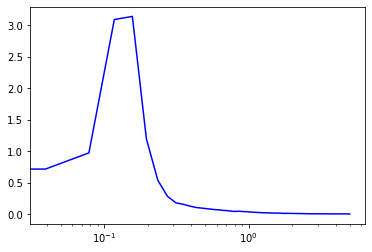

In [103]:
plt.semilogx(freqs[0], mean(psd, axis=0), color='blue')

In [83]:
wind_data_20min[(wind_data_20min['W_a']<0.001) & (wind_data_20min['W_a']>=0.0005)]

,ucm,vcm,wcm,W_total,W_a
time,,,,,
2020-03-04 15:20:00,3.908596,3.965608e-15,-4.319990e-15,0.001189,0.000818
2020-03-04 15:40:00,4.147173,-2.014332e-16,1.903666e-15,0.000420,0.000541
2020-03-04 16:00:00,4.237486,6.450598e-16,-3.558338e-16,0.000671,0.000529
2020-03-05 08:00:00,13.951986,-1.837789e-16,-1.458148e-15,0.000355,0.000913
2020-03-05 08:20:00,14.215264,-3.262252e-14,-9.484011e-15,0.000146,0.000645
2020-03-05 11:40:00,13.577316,-9.727630e-15,-1.177811e-15,0.000000,0.000510
2020-03-05 12:20:00,13.751421,1.572907e-15,7.083854e-15,0.005977,0.000849
2020-03-05 14:00:00,14.246223,-3.691332e-14,-2.267599e-15,0.003123,0.000653
2020-03-05 14:40:00,15.690430,-3.755982e-15,-5.424832e-15,0.003641,0.000739


In [104]:
ttt = [wind_data_20min[(wind_data_20min['W_a']<0.0005) & (wind_data_20min['W_a']>=0)].index, 
       wind_data_20min[(wind_data_20min['W_a']<0.001) & (wind_data_20min['W_a']>=0.0005)].index,
       wind_data_20min[(wind_data_20min['W_a']<0.0015) & (wind_data_20min['W_a']>=0.001)].index,
       wind_data_20min[(wind_data_20min['W_a']<0.002) & (wind_data_20min['W_a']>=0.0015)].index,
       wind_data_20min[wind_data_20min['W_a']>=0.0025].index]

In [105]:
ttt[0]

DatetimeIndex(['2020-03-04 16:20:00', '2020-03-05 08:40:00',
               '2020-03-05 09:00:00', '2020-03-05 09:20:00',
               '2020-03-05 11:20:00', '2020-03-06 07:40:00',
               '2020-03-06 08:00:00', '2020-03-06 08:20:00',
               '2020-03-06 16:40:00', '2020-03-06 17:20:00',
               '2020-03-07 15:40:00'],
              dtype='datetime64[ns]', name='time', freq=None)

In [107]:
ttt[0][0]

Timestamp('2020-03-04 16:20:00')

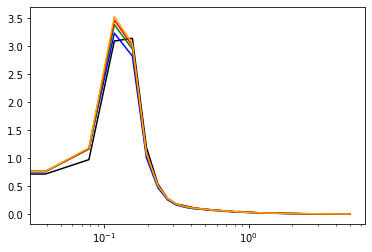

In [112]:
ttt = [wind_data_20min[(wind_data_20min['W_a']<0.0005) & (wind_data_20min['W_a']>=0)].index, 
       wind_data_20min[(wind_data_20min['W_a']<0.001) & (wind_data_20min['W_a']>=0.0005)].index,
       wind_data_20min[(wind_data_20min['W_a']<0.0015) & (wind_data_20min['W_a']>=0.001)].index,
       wind_data_20min[(wind_data_20min['W_a']<0.002) & (wind_data_20min['W_a']>=0.0015)].index,
       wind_data_20min[wind_data_20min['W_a']>=0.0025].index]
freqs = []
psd = []
colors_seq = ['black', 'blue', 'green', 'red', 'orange']
for j in np.arange(5):
    for i in np.arange(len(ttt[j])):
        fff, ppp = signal.welch(wind_data[ttt[j][i]:(ttt[j][i] +datetime.timedelta(minutes=19))]['wc'].values, fs=10)
        freqs.append(fff)
        psd.append(ppp)
    plt.semilogx(freqs[0], mean(psd, axis=0), color=colors_seq[j])

#根据结果可以看出，随着active whitecap fraction的增加，功率谱也在增加

In [121]:
p = np.polyfit(np.arange(len(wind_data[ttt[j][i]:(ttt[j][i] +datetime.timedelta(minutes=19))]['uc'].values)),
               wind_data[ttt[j][i]:(ttt[j][i] +datetime.timedelta(minutes=19))]['uc'].values, 1)
ddd_notrend = wind_data[ttt[j][i]:(ttt[j][i] +datetime.timedelta(minutes=19))]['uc'].values - np.polyval(p, np.arange(len(wind_data[ttt[j][i]:(ttt[j][i] +datetime.timedelta(minutes=19))]['uc'].values)))

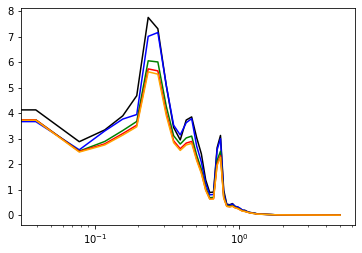

In [122]:
ttt = [wind_data_20min[(wind_data_20min['W_a']<0.0005) & (wind_data_20min['W_a']>=0)].index, 
       wind_data_20min[(wind_data_20min['W_a']<0.001) & (wind_data_20min['W_a']>=0.0005)].index,
       wind_data_20min[(wind_data_20min['W_a']<0.0015) & (wind_data_20min['W_a']>=0.001)].index,
       wind_data_20min[(wind_data_20min['W_a']<0.002) & (wind_data_20min['W_a']>=0.0015)].index,
       wind_data_20min[wind_data_20min['W_a']>=0.0025].index]
freqs = []
psd = []
colors_seq = ['black', 'blue', 'green', 'red', 'orange']
for j in np.arange(5):
    for i in np.arange(len(ttt[j])):
        p = np.polyfit(np.arange(len(wind_data[ttt[j][i]:(ttt[j][i] +datetime.timedelta(minutes=19))]['uc'].values)),
               wind_data[ttt[j][i]:(ttt[j][i] +datetime.timedelta(minutes=19))]['uc'].values, 1)
        ddd_notrend = wind_data[ttt[j][i]:(ttt[j][i] +datetime.timedelta(minutes=19))]['uc'].values 
        - np.polyval(p, np.arange(len(wind_data[ttt[j][i]:(ttt[j][i] +datetime.timedelta(minutes=19))]['uc'].values)))
        
        fff, ppp = signal.welch(ddd_notrend, fs=10)
        freqs.append(fff)
        psd.append(ppp)
    plt.semilogx(freqs[0], mean(psd, axis=0), color=colors_seq[j])



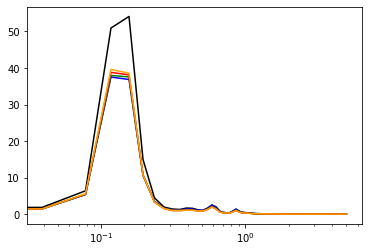

In [123]:
ttt = [wind_data_20min[(wind_data_20min['W_a']<0.0005) & (wind_data_20min['W_a']>=0)].index, 
       wind_data_20min[(wind_data_20min['W_a']<0.001) & (wind_data_20min['W_a']>=0.0005)].index,
       wind_data_20min[(wind_data_20min['W_a']<0.0015) & (wind_data_20min['W_a']>=0.001)].index,
       wind_data_20min[(wind_data_20min['W_a']<0.002) & (wind_data_20min['W_a']>=0.0015)].index,
       wind_data_20min[wind_data_20min['W_a']>=0.0025].index]
freqs = []
psd = []
colors_seq = ['black', 'blue', 'green', 'red', 'orange']
for j in np.arange(5):
    for i in np.arange(len(ttt[j])):
        p = np.polyfit(np.arange(len(wind_data[ttt[j][i]:(ttt[j][i] +datetime.timedelta(minutes=19))]['vc'].values)),
               wind_data[ttt[j][i]:(ttt[j][i] +datetime.timedelta(minutes=19))]['vc'].values, 1)
        ddd_notrend = wind_data[ttt[j][i]:(ttt[j][i] +datetime.timedelta(minutes=19))]['vc'].values 
        - np.polyval(p, np.arange(len(wind_data[ttt[j][i]:(ttt[j][i] +datetime.timedelta(minutes=19))]['vc'].values)))
        
        fff, ppp = signal.welch(ddd_notrend, fs=10)
        freqs.append(fff)
        psd.append(ppp)
    plt.semilogx(freqs[0], mean(psd, axis=0), color=colors_seq[j])




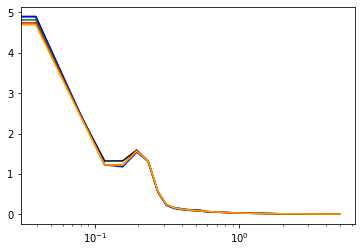

In [120]:
ttt = [wind_data_20min[(wind_data_20min['W_a']<0.0005) & (wind_data_20min['W_a']>=0)].index, 
       wind_data_20min[(wind_data_20min['W_a']<0.001) & (wind_data_20min['W_a']>=0.0005)].index,
       wind_data_20min[(wind_data_20min['W_a']<0.0015) & (wind_data_20min['W_a']>=0.001)].index,
       wind_data_20min[(wind_data_20min['W_a']<0.002) & (wind_data_20min['W_a']>=0.0015)].index,
       wind_data_20min[wind_data_20min['W_a']>=0.0025].index]
freqs = []
psd = []
colors_seq = ['black', 'blue', 'green', 'red', 'orange']
for j in np.arange(5):
    for i in np.arange(len(ttt[j])):
        fff, ppp = signal.welch(sqrt(wind_data[ttt[j][i]:(ttt[j][i] +datetime.timedelta(minutes=19))]['uc'].values**2 +
                                     wind_data[ttt[j][i]:(ttt[j][i] +datetime.timedelta(minutes=19))]['vc'].values**2 +
                                     wind_data[ttt[j][i]:(ttt[j][i] +datetime.timedelta(minutes=19))]['wc'].values**2), fs=10)
        freqs.append(fff)
        psd.append(ppp)
    plt.semilogx(freqs[0], mean(psd, axis=0), color=colors_seq[j])

In [84]:
wind_data_20min[(wind_data_20min['W_a']<0.0015) & (wind_data_20min['W_a']>=0.001)]

,ucm,vcm,wcm,W_total,W_a
time,,,,,
2020-03-04 15:00:00,4.633596,1.021764e-15,-9.126198e-16,0.000000,0.001102
2020-03-05 12:00:00,13.059120,3.593048e-15,-4.502227e-15,0.004505,0.001087
2020-03-05 12:40:00,13.429634,-4.285522e-14,5.648344e-16,0.004109,0.001037
2020-03-05 13:00:00,13.922965,1.093619e-14,-3.458010e-15,0.004124,0.001281
2020-03-05 13:20:00,14.137556,-6.793925e-15,5.042370e-15,0.005110,0.001218
2020-03-05 13:40:00,13.961271,-5.568718e-14,1.364757e-15,0.006482,0.001313
2020-03-05 15:00:00,14.942490,-4.859559e-15,-8.594843e-15,0.004718,0.001006
2020-03-05 16:00:00,16.692460,-2.683607e-14,1.016880e-15,0.008426,0.001474
2020-03-05 17:00:00,17.892079,-8.929594e-15,1.353543e-14,0.006737,0.001485


In [85]:
wind_data_20min[(wind_data_20min['W_a']<0.002) & (wind_data_20min['W_a']>=0.0015)]

,ucm,vcm,wcm,W_total,W_a
time,,,,,
2020-03-05 15:20:00,16.147515,-3.229466e-14,1.642605e-14,0.010723,0.001609
2020-03-05 15:40:00,16.560390,-1.227730e-14,6.167349e-15,0.010255,0.001527
2020-03-05 16:20:00,16.930052,-1.305402e-14,6.716660e-15,0.008197,0.001627
2020-03-06 06:40:00,13.075701,-1.255650e-14,-3.182313e-15,0.011605,0.001591
2020-03-06 10:20:00,15.836038,-4.199542e-14,-9.910154e-15,0.000000,0.001956


In [86]:
wind_data_20min[wind_data_20min['W_a']>=0.0025]

,ucm,vcm,wcm,W_total,W_a
time,,,,,
2020-03-06 11:00:00,15.596419,5.031852e-16,4.839799e-16,0.000000,0.002519
2020-03-06 11:40:00,15.043883,-2.039391e-14,4.134626e-15,0.013037,0.002563
